In [1]:
# Import

import numpy
import pandas
import torch

import sys
sys.path.append('..')

from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.decomposition import Decomposition
from harmonica.model import Model
from harmonica.table import Table
from harmonica.twiss import Twiss

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = 'cpu'

# Example-01: Twiss from amplitude data

In [3]:
# In this example twiss beta values are estimated from amplitude data
# Signals are generated using exact model with random noise added on top
# In this case result error is due to the noise alone

# Given the TbT data, the main frequency and correcponding parameters (amplitude and phase) are estimated for x & y planes
# Amplitude data is used to estimate twiss beta values
# Model beta values are used to estimate action at each monitor location
# Total action is estimated using actions from all monitors with optional outlier filtering

In [4]:
# Compute reference parameters (frequency, amplitude and phase)

df = pandas.read_pickle('../virtual_tbt.pkl.gz')

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, torch.tensor(df.X.to_list(), dtype=dtype, device=device))
y = Data.from_data(w, torch.tensor(df.Y.to_list(), dtype=dtype, device=device))

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [5]:
# Set noise

noise_x = 1.0E-6*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-6*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

nux=  0.53688314, sigma_nux=6.34913707e-07, error_nux=4.10219707e-08

(ax - ref_ax).abs().sum().item()=9.9012442e-05

(fx - ref_fx).abs().sum().item()=0.0407305572



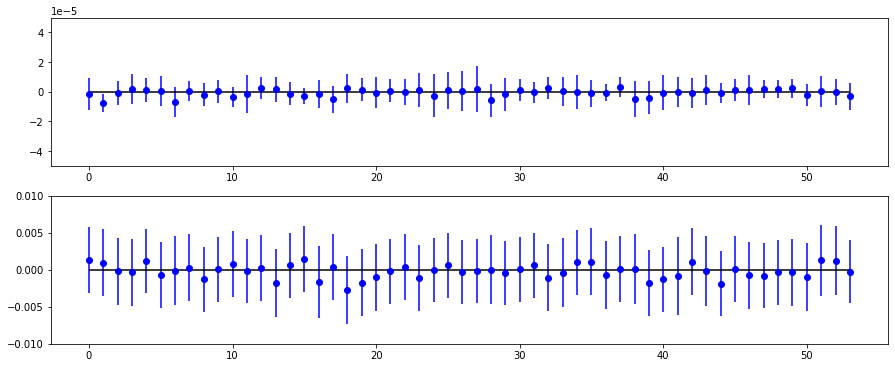

In [6]:
# Compute frequency, amplitude and phase for x plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=64, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=256, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(x.size), (ax - ref_ax).cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, x.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(x.size), (fx - ref_fx).cpu().numpy(), yerr=sigma_fx.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, x.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

nuy= 0.576774739, sigma_nuy=7.28960398e-07, error_nuy=1.06110087e-07

(ay - ref_ay).abs().sum().item()=9.77316778e-05

(fy - ref_fy).abs().sum().item()=0.0499955086



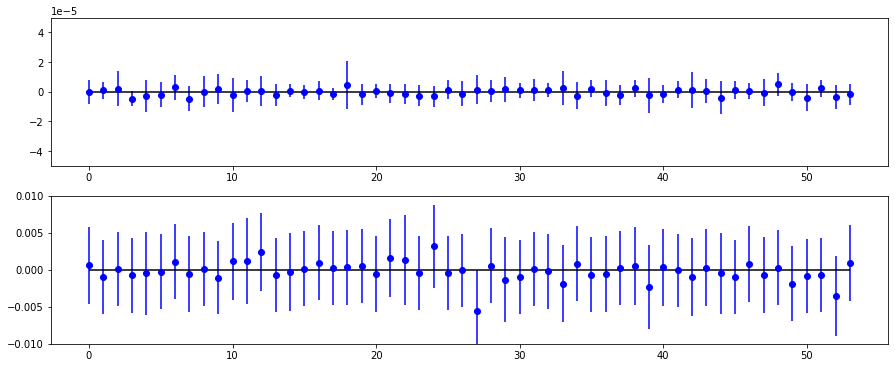

In [7]:
# Compute frequency, amplitude and phase for y plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=64, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=256, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(y.size), (ay - ref_ay).cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, y.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(y.size), (fy - ref_fy).cpu().numpy(), yerr=sigma_fy.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, y.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

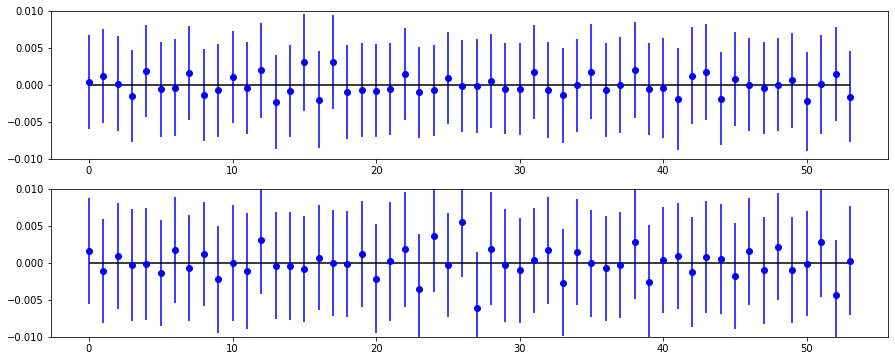

In [8]:
# Set model & table

model = Model(path='../config.yaml', dtype=dtype, device=device)
table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

# Compare phase advance between adjacent monitor locations

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (model.monitor_phase_x - table.phase_x).cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-1.0E-2, +1.0E-2)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (model.monitor_phase_y - table.phase_y).cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)

plt.show()

In [9]:
# Set twiss instance

twiss = Twiss(model, table, use_model=False)

dict_keys(['jx', 'sigma_jx', 'center_jx', 'spread_jx', 'jy', 'sigma_jy', 'center_jy', 'spread_jy', 'mask'])

(abs(ref_jx - center_jx)/ref_jx).item() = 0.000148313529
(abs(ref_jy - center_jy)/ref_jy).item() = 4.64144934e-05



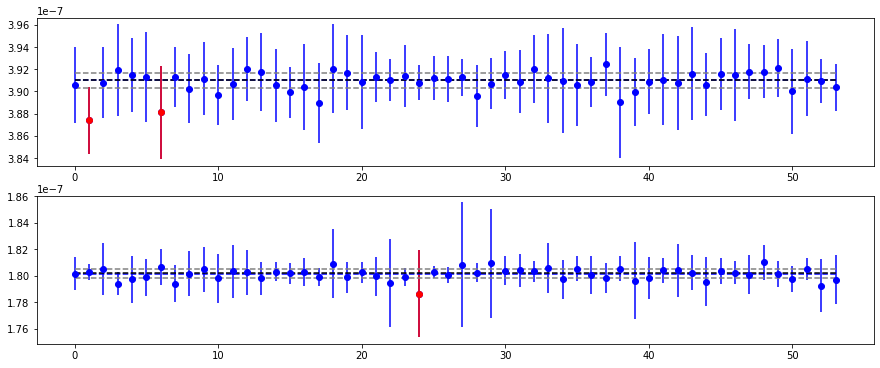

In [10]:
# Estimate action

twiss.get_action(data_threshold={'use': True, 'factor': 3.0})
print(twiss.action.keys())
print()

jx, sigma_jx, center_jx, spread_jx = twiss.action['jx'], twiss.action['sigma_jx'], twiss.action['center_jx'], twiss.action['spread_jx']
jy, sigma_jy, center_jy, spread_jy = twiss.action['jy'], twiss.action['sigma_jy'], twiss.action['center_jy'], twiss.action['spread_jy']

ref_jx = (ref_ax**2/(2.0*model.bx[model.monitor_index])).mean()
ref_jy = (ref_ay**2/(2.0*model.by[model.monitor_index])).mean()

print(f'{(abs(ref_jx - center_jx)/ref_jx).item() = :12.9}')
print(f'{(abs(ref_jy - center_jy)/ref_jy).item() = :12.9}')
print()

mask_x, mask_y = twiss.action['mask'].logical_not()
out_jx, out_jy = torch.arange(model.monitor_count)[mask_x], torch.arange(model.monitor_count)[mask_y]

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), jx.cpu().numpy(), yerr=sigma_jx.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.errorbar(out_jx.cpu().numpy(), jx[out_jx].cpu().numpy(), yerr=sigma_jx[out_jx].cpu().numpy(), fmt=' ', marker='o', color='red')
ax1.hlines([(center_jx - spread_jx).cpu().numpy()], 0, model.monitor_count - 1, colors='gray', linestyles='dashed')
ax1.hlines([center_jx.cpu().numpy()], 0, model.monitor_count - 1, colors='blue', linestyles='dashed')
ax1.hlines([(center_jx + spread_jx).cpu().numpy()], 0, model.monitor_count - 1, colors='gray', linestyles='dashed')
ax1.hlines([ref_jx.cpu().numpy()], 0, model.monitor_count - 1, colors='black', linestyles='dashed')


ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), jy.cpu().numpy(), yerr=sigma_jy.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.errorbar(out_jy.cpu().numpy(), jy[out_jy].cpu().numpy(), yerr=sigma_jy[out_jy].cpu().numpy(), fmt=' ', marker='o', color='red')
ax2.hlines([(center_jy - spread_jy).cpu().numpy()], 0, model.monitor_count - 1, colors='gray', linestyles='dashed')
ax2.hlines([center_jy.cpu().numpy()], 0, model.monitor_count - 1, colors='blue', linestyles='dashed')
ax2.hlines([(center_jy + spread_jy).cpu().numpy()], 0, model.monitor_count - 1, colors='gray', linestyles='dashed')
ax2.hlines([ref_jy.cpu().numpy()], 0, model.monitor_count - 1, colors='black', linestyles='dashed')

plt.show()

dict_keys(['bx', 'sigma_bx', 'by', 'sigma_by'])

(bx - model.bx[model.monitor_index]).abs().sum().item()= 0.611579473
(by - model.by[model.monitor_index]).abs().sum().item()=  1.18418468



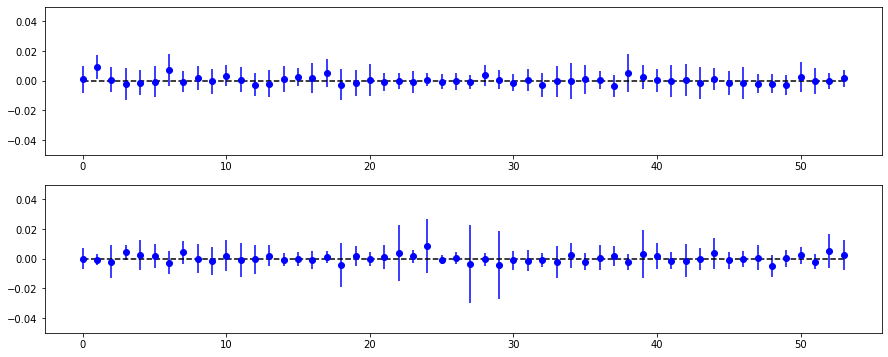

In [11]:
# Estimate twiss beta

twiss.get_twiss_from_amplitude()
print(twiss.data_amplitude.keys())
print()

bx, sigma_bx = twiss.data_amplitude['bx'], twiss.data_amplitude['sigma_bx']
by, sigma_by = twiss.data_amplitude['by'], twiss.data_amplitude['sigma_by']

bx_m = model.bx[model.monitor_index]
by_m = model.by[model.monitor_index]

print(f'{(bx - model.bx[model.monitor_index]).abs().sum().item()=:12.9}')
print(f'{(by - model.by[model.monitor_index]).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), ((bx_m - bx)/bx_m).cpu().numpy(), yerr=(sigma_bx/bx_m).cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black', linestyles='dashed')
ax1.set_ylim(-0.05, +0.05)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), ((by_m - by)/by_m).cpu().numpy(), yerr=(sigma_by/by_m).cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black', linestyles='dashed')
ax2.set_ylim(-0.05, +0.05)

plt.show()

# Example-02: Virtual phase and phase correction

In [12]:
# TbT data is only avalible at monitor locations
# Phase at other locations of interest (virtual locations) can be estimated using measured phase at monitors and model advance between them
# For each virtual location, monitor locations around it are used to estimate virtual phase
# Given range limit, the corresponding number of monitors are used on each side around the probed virtual location

# Similary, monitor location itself can be treated as a virtual location, i.e. data from other locations can be used to impove estimation at selected probed location
# Strong bias towards model is introduced in this case, i.e. phase correction should be avoided if real lattice is not close to the model
# Phase at the probed monitor is not used, but can be added or compared with measured phase

# In both cases, the range limit is passed to the method

In [13]:
# Compute reference parameters (frequency, amplitude and phase)

df = pandas.read_pickle('../virtual_tbt.pkl.gz')

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, torch.tensor(df.X.to_list(), dtype=dtype, device=device))
y = Data.from_data(w, torch.tensor(df.Y.to_list(), dtype=dtype, device=device))

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [14]:
# Set noise

noise_x = 1.0E-6*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-6*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

nux= 0.536883122, sigma_nux=6.70569901e-07, error_nux=2.362219e-08

(ax - ref_ax).abs().sum().item()=8.93885662e-05

(fx - ref_fx).abs().sum().item()=0.0347477462



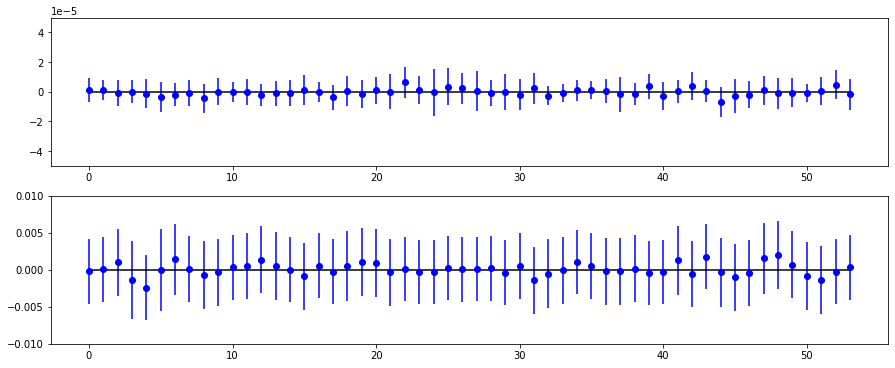

In [15]:
# Compute frequency, amplitude and phase for x plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=64, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=256, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(x.size), (ax - ref_ax).cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, x.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(x.size), (fx - ref_fx).cpu().numpy(), yerr=sigma_fx.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, x.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

nuy= 0.576774732, sigma_nuy=6.60086292e-07, error_nuy=9.83802229e-08

(ay - ref_ay).abs().sum().item()=8.37444667e-05

(fy - ref_fy).abs().sum().item()=0.0369491446



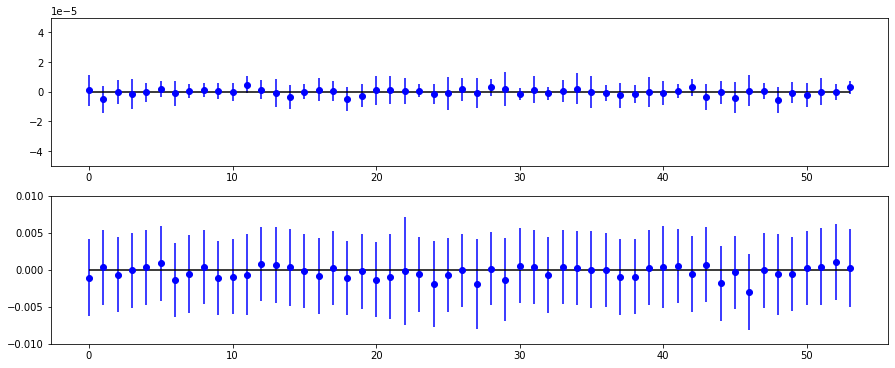

In [16]:
# Compute frequency, amplitude and phase for y plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=64, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=256, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(y.size), (ay - ref_ay).cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, y.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(y.size), (fy - ref_fy).cpu().numpy(), yerr=sigma_fy.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, y.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

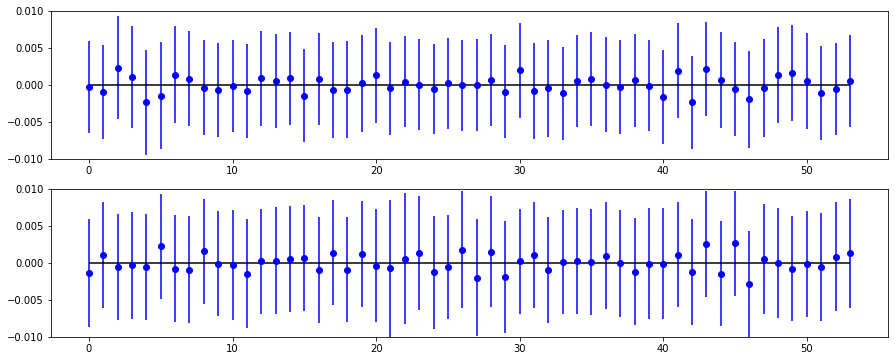

In [17]:
# Set model & table

model = Model(path='../config.yaml', dtype=dtype, device=device)
table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

# Compare phase advance between adjacent monitor locations

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (model.monitor_phase_x - table.phase_x).cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-1.0E-2, +1.0E-2)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (model.monitor_phase_y - table.phase_y).cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)

plt.show()

In [18]:
# Set twiss instance

twiss = Twiss(model, table)

In [19]:
# Print total number of virtual locations and corresponding index
# Note, the first and the last are special virtual locations ('HEAD' and 'TAIL')

print(twiss.model.virtual_count)
print(twiss.model.virtual_index)

# Compute virtual phase at each virtual location
# twiss.fx, twiss.fy and corresponding error are updated (zero at initialization at virtual location indices)
# twiss.correct_x and twiss.correct_y dictionaries with additional information are created or updated
# Note, kwargs can be passed to Decomposition.phase_virtual()

twiss.phase_virtual(limit=8, clean=True, factor=2.0)

5
[0, 2, 28, 54, 58]


dict_keys(['model', 'probe', 'limit', 'index', 'clean', 'phase', 'error'])
tensor([1.020623356201e+00, 4.752335780892e-04], dtype=torch.float64)
28
8
{20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36}
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1])


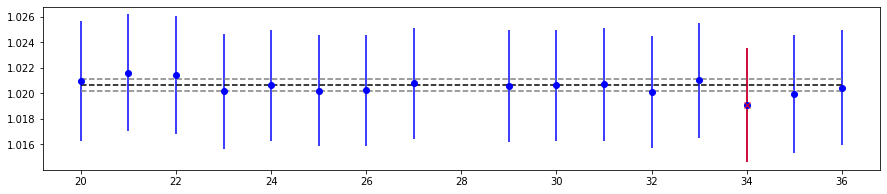

In [20]:
# Examine additional data for a virtual location at IP

_, _, index, *_ = twiss.model.virtual_index

# For each virtual location, addition data dictionary is stored

print(twiss.virtual_x[index].keys())

# Estimated value & error

print(twiss.virtual_x[index]['model'])

# Virtual location index

print(twiss.virtual_x[index]['probe'])

# Range limit

print(twiss.virtual_x[index]['limit'])

# Used locations {index: location}

print(twiss.virtual_x[index]['index'])

# Filter mask

print(twiss.virtual_x[index]['clean'].to(torch.int64))

# Plot phase data and error

keys = torch.tensor([*twiss.virtual_x[index]['index'].keys()], dtype=torch.int64)
mask = twiss.virtual_x[index]['clean'].logical_not()

center, spread = twiss.virtual_x[index]['model'].cpu().numpy()

plt.figure(figsize=(15, 3))
plt.errorbar(keys, twiss.virtual_x[index]['phase'].cpu().numpy(), yerr=twiss.virtual_x[index]['error'].cpu().numpy(), fmt=' ', color='blue', marker='o')
plt.errorbar(keys[mask], twiss.virtual_x[index]['phase'][mask].cpu().numpy(), yerr=twiss.virtual_x[index]['error'][mask].cpu().numpy(), fmt=' ', color='red', marker='x')
plt.hlines([center - spread, center, center + spread], min(keys), max(keys), color=['grey', 'black', 'grey'], linestyles='dashed')
plt.show()

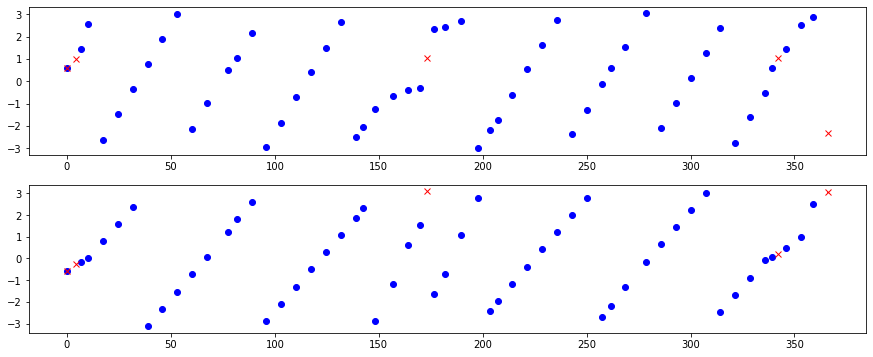

In [21]:
# Plot x & y phase for all locations vs location position

# blue -- monitor locations
# red  -- virtual locations

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.fx[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_fx[model.monitor_index].cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.errorbar(model.time[model.virtual_index].cpu().numpy(), twiss.fx[model.virtual_index].cpu().numpy(), yerr=twiss.sigma_fx[model.virtual_index].cpu().numpy(), fmt=' ', marker='x', color='red')

ax2 = plt.subplot(212)
ax2.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.fy[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_fy[model.monitor_index].cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.errorbar(model.time[model.virtual_index].cpu().numpy(), twiss.fy[model.virtual_index].cpu().numpy(), yerr=twiss.sigma_fy[model.virtual_index].cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

In [22]:
# Perform phase correction
# Note, kwargs are passed to Decomposition.phase_virtual()

# Similar to virtual phase computation, twiss.correct_x & twiss.correct_y dictionaries are created or updated
# twiss.fx_correct, twiss.fy_correct attributes and corresponding errors are created

twiss.phase_correct(limit=8, clean=True, factor=2.0)

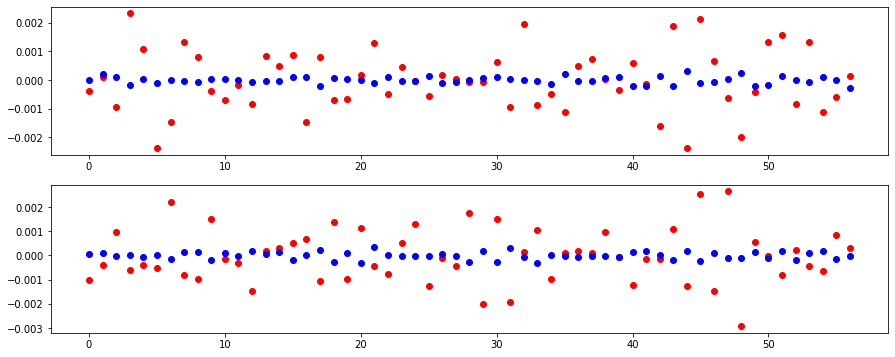

(mux - twiss.model.phase_x)[1:-1].abs().sum().item()=0.0489916065
(muy - twiss.model.phase_y)[1:-1].abs().sum().item()= 0.050373625

(mux_correct - twiss.model.phase_x)[1:-1].abs().sum().item()=0.00550665344
(muy_correct - twiss.model.phase_y)[1:-1].abs().sum().item()=0.00687204719



In [23]:
# Compare adjacent phase advance for uncorrected and corrected case vs model (endpoints are dropped)

# Uncorrected

mux, _ = Decomposition.phase_adjacent(twiss.table.nux, twiss.fx)
muy, _ = Decomposition.phase_adjacent(twiss.table.nuy, twiss.fy)

# Corrected

mux_correct, _ = Decomposition.phase_adjacent(twiss.table.nux, twiss.fx_correct)
muy_correct, _ = Decomposition.phase_adjacent(twiss.table.nuy, twiss.fy_correct)

# Plot

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.scatter(range(twiss.model.size - (1 + 1)), (twiss.model.phase_x - mux)[1:-1].cpu().numpy(), color='red', marker='o')
ax1.scatter(range(twiss.model.size - (1 + 1)), (twiss.model.phase_x - mux_correct)[1:-1].cpu().numpy(), color='blue', marker='o')

ax2 = plt.subplot(212)
ax2.scatter(range(twiss.model.size - (1 + 1)), (twiss.model.phase_y - muy)[1:-1].cpu().numpy(), color='red', marker='o')
ax2.scatter(range(twiss.model.size - (1 + 1)), (twiss.model.phase_y - muy_correct)[1:-1].cpu().numpy(), color='blue', marker='o')

plt.show()

print(f'{(mux - twiss.model.phase_x)[1:-1].abs().sum().item()=:12.9}')
print(f'{(muy - twiss.model.phase_y)[1:-1].abs().sum().item()=:12.9}')
print()

print(f'{(mux_correct - twiss.model.phase_x)[1:-1].abs().sum().item()=:12.9}')
print(f'{(muy_correct - twiss.model.phase_y)[1:-1].abs().sum().item()=:12.9}')
print()

# Example-03: Twiss from phase data (adjacent)

In [24]:
# In this example, twiss parameters are computed from phase data using only adjacent monitors, i.e. range limit is one
# Results are compared with model
# Twiss beta values are also compared with twiss from amplitude data computation

In [25]:
# Compute reference parameters (frequency, amplitude and phase)

df = pandas.read_pickle('../virtual_tbt.pkl.gz')

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, torch.tensor(df.X.to_list(), dtype=dtype, device=device))
y = Data.from_data(w, torch.tensor(df.Y.to_list(), dtype=dtype, device=device))

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [26]:
# Set noise

noise_x = 1.0E-6*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-6*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

nux= 0.536883107, sigma_nux=5.64295594e-07, error_nux=8.32700897e-09

(ax - ref_ax).abs().sum().item()=8.72084493e-05

(fx - ref_fx).abs().sum().item()=0.0279647371



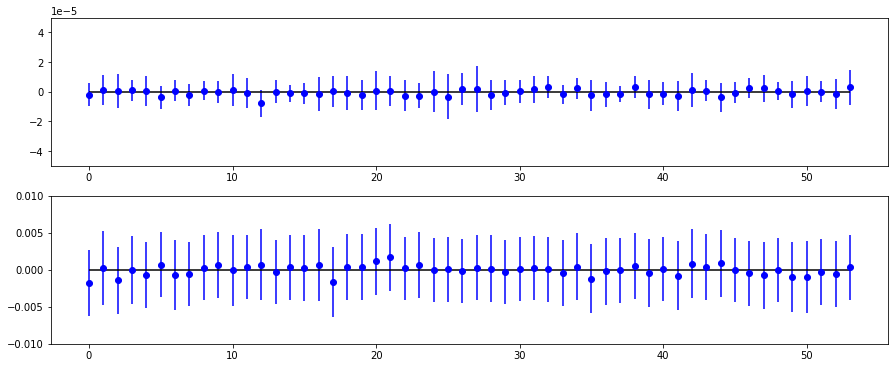

In [27]:
# Compute frequency, amplitude and phase for x plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=64, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=256, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(x.size), (ax - ref_ax).cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, x.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(x.size), (fx - ref_fx).cpu().numpy(), yerr=sigma_fx.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, x.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

nuy= 0.576774567, sigma_nuy=8.71876856e-07, error_nuy=6.6005025e-08

(ay - ref_ay).abs().sum().item()=0.000113177892

(fy - ref_fy).abs().sum().item()=0.0356983508



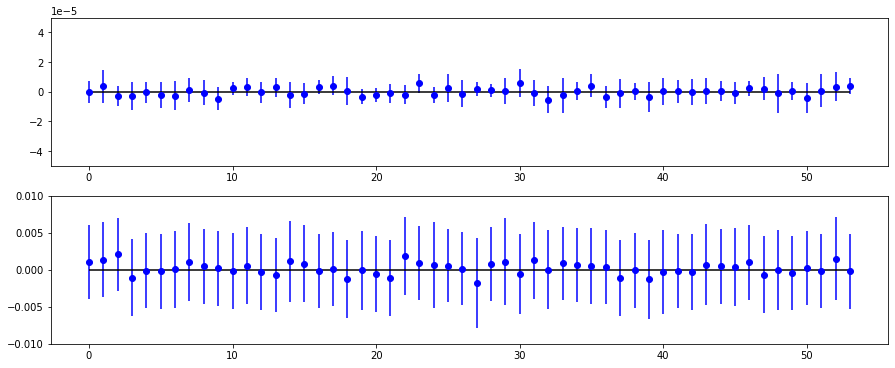

In [28]:
# Compute frequency, amplitude and phase for y plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=64, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=256, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(y.size), (ay - ref_ay).cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, y.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(y.size), (fy - ref_fy).cpu().numpy(), yerr=sigma_fy.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, y.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

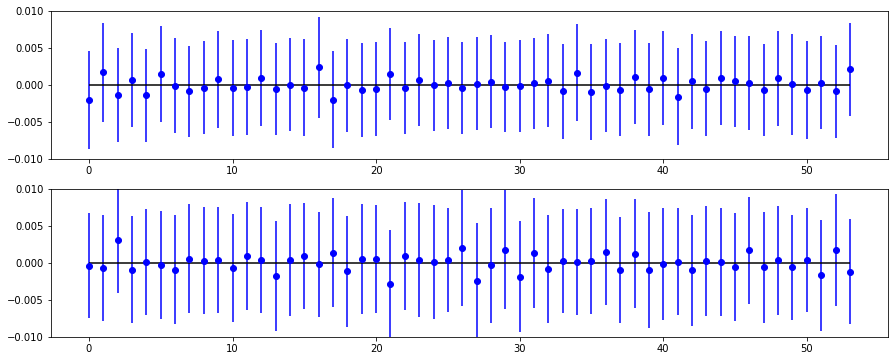

In [29]:
# Set model & table

model = Model(path='../config.yaml', dtype=dtype, device=device)
table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

# Compare phase advance between adjacent monitor locations

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (model.monitor_phase_x - table.phase_x).cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-1.0E-2, +1.0E-2)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (model.monitor_phase_y - table.phase_y).cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)

plt.show()

In [30]:
# Set twiss instance

twiss = Twiss(model, table, limit=1)

# Estimate twiss from amplitude data

twiss.get_action()
twiss.get_twiss_from_amplitude()

# Estimate twiss from phase data
# Note, virtual locations are not used as other for given probe

twiss.phase_virtual()
twiss.get_twiss_from_phase()

In [31]:
# Invocation of get_twiss_from_phase sets twiss.data_phase dictionary
# This dictionary contains model and estimated results for each triplet (phase advance, twiss parameters and corresponding errors)

for key in twiss.data_phase:
    print(key)
    
# i -- probed index, j & k -- other used indices, each combination is given by two pairs (i, j) & (i, k), phase advance is always from i and is negative if i is behind j or k timewise

# fx_ij, fx_m_ij -- estimated and model phase advance for i to j or k for x plane and corresponding errors with 'sigma' prefix
# fy_ij, fy_m_ij -- estimated and model phase advance for i to j or k for y plane and corresponding errors with 'sigma' prefix

# ax, bx -- estimated twiss parameters and corresponding error for x plane and corresponding errors with 'sigma' prefix
# ay, by -- estimated twiss parameters and corresponding error for y plane and corresponding errors with 'sigma' prefix

fx_ij
sigma_fx_ij
fx_m_ij
sigma_fx_m_ij
fx_ik
sigma_fx_ik
fx_m_ik
sigma_fx_m_ik
fy_ij
sigma_fy_ij
fy_m_ij
sigma_fy_m_ij
fy_ik
sigma_fy_ik
fy_m_ik
sigma_fy_m_ik
ax
sigma_ax
bx
sigma_bx
ay
sigma_ay
by
sigma_by


In [32]:
# Since range limit is one here, each location has only one computed value

print(twiss.data_phase['bx'].shape)

torch.Size([59, 1])


In [33]:
# Note, here 'HEAD' virtual location is at the same place as the 1st monitor location
# Phase advance in this case is zero and twiss parameters are not meaningful for 'HEAD' virtual location

print(model.is_same(0, 1))

True


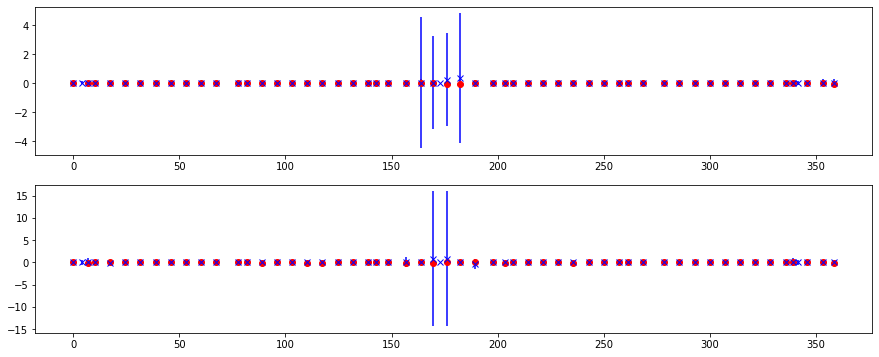

(bx_m[twiss.model.monitor_index] - bx_a).abs().sum().item()=  0.57362204
(by_m[twiss.model.monitor_index] - by_a).abs().sum().item()=  1.39734812

(bx_m - bx_f)[1:-1].abs().sum().item()= 0.974202612
(by_m - by_f)[1:-1].abs().sum().item()=   2.8841821



In [34]:
# Plot twiss beta results ('HEAD' and 'TAIL' virtual locations are dropped)
# Note, relative error is plotted

# Model

bx_m, by_m = twiss.model.bx, twiss.model.by

# Twiss from amplitude

bx_a, sigma_bx_a = twiss.data_amplitude['bx'], twiss.data_amplitude['sigma_bx']
by_a, sigma_by_a = twiss.data_amplitude['by'], twiss.data_amplitude['sigma_by']

# Twiss from phase

bx_f, sigma_bx_f = twiss.data_phase['bx'].flatten(), twiss.data_phase['sigma_bx'].flatten()
by_f, sigma_by_f = twiss.data_phase['by'].flatten(), twiss.data_phase['sigma_by'].flatten()

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (bx_m[twiss.model.monitor_index] - bx_a).cpu().numpy(), yerr=sigma_bx_a.cpu().numpy(), fmt=' ', marker='o', color='red')
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), (bx_m - bx_f)[1:-1].cpu().numpy(), yerr=sigma_bx_f[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')

ax2 = plt.subplot(212)
ax2.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (by_m[twiss.model.monitor_index] - by_a).cpu().numpy(), yerr=sigma_by_a.cpu().numpy(), fmt=' ', marker='o', color='red')
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), (by_m - by_f)[1:-1].cpu().numpy(), yerr=sigma_by_f[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')

plt.show()

print(f'{(bx_m[twiss.model.monitor_index] - bx_a).abs().sum().item()=:12.9}')
print(f'{(by_m[twiss.model.monitor_index] - by_a).abs().sum().item()=:12.9}')
print()

print(f'{(bx_m - bx_f)[1:-1].abs().sum().item()=:12.9}')
print(f'{(by_m - by_f)[1:-1].abs().sum().item()=:12.9}')
print()

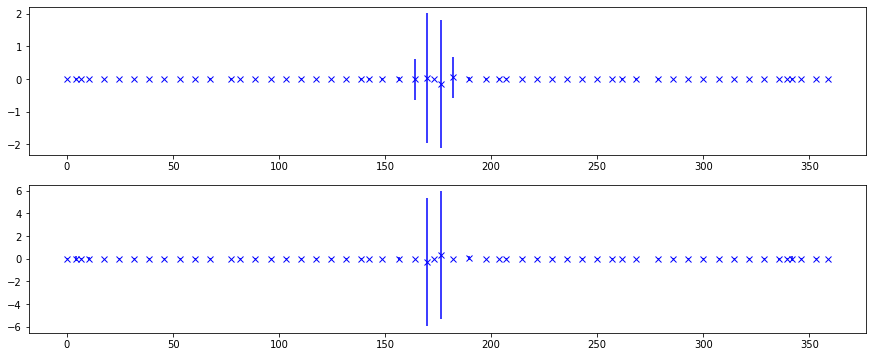

(ax_m - ax_f)[1:-1].abs().sum().item()= 0.311652023
(ay_m - ay_f)[1:-1].abs().sum().item()= 0.821472186



In [35]:
# Plot twiss alpha results ('HEAD' and 'TAIL' virtual locations are dropped)
# Note, relative error is plotted

# Model

ax_m, ay_m = twiss.model.ax, twiss.model.ay

# Twiss from phase

ax_f, sigma_ax_f = twiss.data_phase['ax'].flatten(), twiss.data_phase['sigma_ax'].flatten()
ay_f, sigma_ay_f = twiss.data_phase['ay'].flatten(), twiss.data_phase['sigma_ay'].flatten()

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), (ax_m - ax_f)[1:-1].cpu().numpy(), yerr=sigma_ax_f[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')

ax2 = plt.subplot(212)
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), (ay_m - ay_f)[1:-1].cpu().numpy(), yerr=sigma_ay_f[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')

plt.show()

print(f'{(ax_m - ax_f)[1:-1].abs().sum().item()=:12.9}')
print(f'{(ay_m - ay_f)[1:-1].abs().sum().item()=:12.9}')
print()

# Example-04: Twiss from phase data (range limit & phase correction)

In [36]:
# In this example several combinations (triplets = two diffrent pairs that include probe and two other) are used to estimate twiss parameters for given probed location
# For each combination twiss parameters and corresponding errors are computed
# Data from different combinations can be filtered (remove outlires) and processed (center and spread estimation)

# Twiss parameters are also computed using corrected phase
# Note, phase correction generates strong bias towards the used model
# In this example signals are generated using exact model and this bias is not manifested

In [37]:
# Compute reference parameters (frequency, amplitude and phase)

df = pandas.read_pickle('../virtual_tbt.pkl.gz')

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, torch.tensor(df.X.to_list(), dtype=dtype, device=device))
y = Data.from_data(w, torch.tensor(df.Y.to_list(), dtype=dtype, device=device))

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [38]:
# Set noise

noise_x = 1.0E-6*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-6*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

nux=  0.53688315, sigma_nux=5.71236884e-07, error_nux=5.15165157e-08

(ax - ref_ax).abs().sum().item()=0.000101800331

(fx - ref_fx).abs().sum().item()=0.0433350642



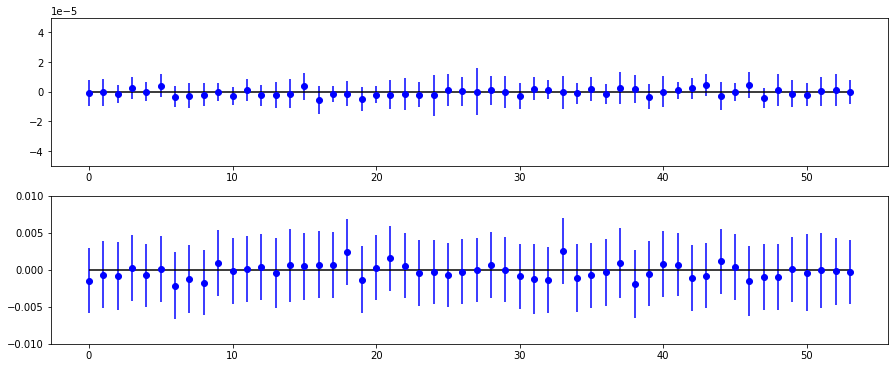

In [39]:
# Compute frequency, amplitude and phase for x plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=64, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=256, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(x.size), (ax - ref_ax).cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, x.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(x.size), (fx - ref_fx).cpu().numpy(), yerr=sigma_fx.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, x.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

nuy= 0.576774823, sigma_nuy=8.19515667e-07, error_nuy=1.89580578e-07

(ay - ref_ay).abs().sum().item()=0.00010229511

(fy - ref_fy).abs().sum().item()=0.0523221259



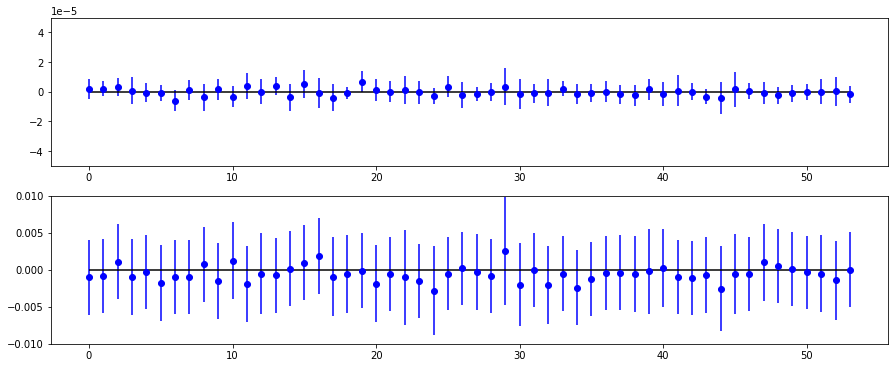

In [40]:
# Compute frequency, amplitude and phase for y plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=64, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=256, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(y.size), (ay - ref_ay).cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, y.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(y.size), (fy - ref_fy).cpu().numpy(), yerr=sigma_fy.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, y.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

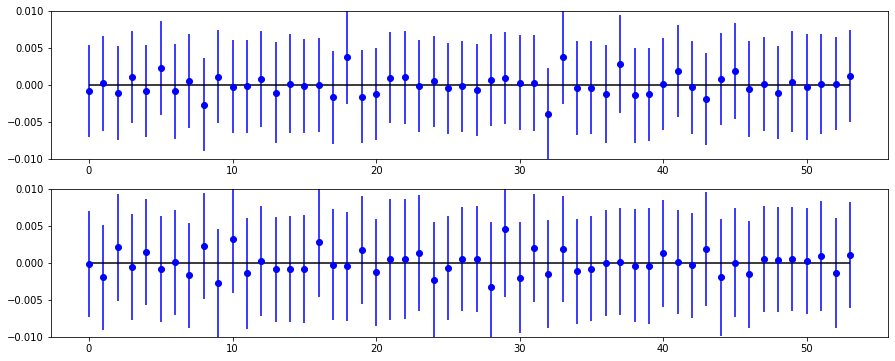

In [41]:
# Set model & table

model = Model(path='../config.yaml', dtype=dtype, device=device)
table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

# Compare phase advance between adjacent monitor locations

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (model.monitor_phase_x - table.phase_x).cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-1.0E-2, +1.0E-2)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (model.monitor_phase_y - table.phase_y).cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)

plt.show()

In [42]:
# Estimate twiss parameters using adjacent monitors
# For each probed location the closest monitor location is used on each side

# Set twiss instance

twiss = Twiss(model, table, limit=1)

# Estimate twiss from amplitude data

twiss.get_action()
twiss.get_twiss_from_amplitude()

# Estimate twiss from phase data
# Note, virtual locations are not used as other for given probe

twiss.phase_virtual()
twiss.get_twiss_from_phase()

# Twiss from amplitude

bx_a, sigma_bx_a = twiss.data_amplitude['bx'], twiss.data_amplitude['sigma_bx']
by_a, sigma_by_a = twiss.data_amplitude['by'], twiss.data_amplitude['sigma_by']

# Twiss from phase

bx_f, sigma_bx_f = twiss.data_phase['bx'].flatten(), twiss.data_phase['sigma_bx'].flatten()
by_f, sigma_by_f = twiss.data_phase['by'].flatten(), twiss.data_phase['sigma_by'].flatten()

ax_f, sigma_ax_f = twiss.data_phase['ax'].flatten(), twiss.data_phase['sigma_ax'].flatten()
ay_f, sigma_ay_f = twiss.data_phase['ay'].flatten(), twiss.data_phase['sigma_ay'].flatten()

In [43]:
# Estimate using range of monitors
# Here, for each probed location 8 monitor locations are used on each side

twiss = Twiss(model, table, limit=8)
twiss.phase_virtual()
twiss.get_twiss_from_phase()

In [44]:
# Note, for given range limit, the number of combinations is limit*(2*limit - 1)

print(max(twiss.limit))
print(max(twiss.limit)*(2*max(twiss.limit) - 1))
print(twiss.data_phase['bx'].shape)

8
120
torch.Size([59, 120])


In [45]:
# Pairs are also generated for each location
# Note, virtual locations do not appear as other indices
# Combinations are also sorted by limit

print(twiss.combo[0].shape)
print(twiss.combo[0, 0].cpu().numpy().tolist())
# [[i, j], [i, k]]

torch.Size([120, 2, 2])
[[0, -2], [0, 1]]


In [46]:
# Data filtering can be performed with filter_twiss method (filtering is performed for x or y plane at a time)
# This method returns a mask with True/False values, True if a combination passes all filtering methods and False otherwise
# This mask can be used as weights, i.e. combinations with False have zero weight

# Several filtering options are avaliable (by default all are used)
# Set 'use' value to True or False

mask_x = twiss.filter_twiss(plane='x',
                            phase={'use': True, 'threshold': 10.0},
                            model={'use': True, 'threshold': 0.5},
                            value={'use': True, 'threshold': 0.5},
                            sigma={'use': True, 'threshold': 0.25},
                            limit={'use': True, 'threshold': 5.0},
                           )

mask_y = twiss.filter_twiss(plane='y',
                            phase={'use': True, 'threshold': 10.0},
                            model={'use': True, 'threshold': 0.5},
                            value={'use': True, 'threshold': 0.5},
                            sigma={'use': True, 'threshold': 0.25},
                            limit={'use': True, 'threshold': 5.0},
                           )

# phase -- clean based on absolute cotangents value for (i, j) or (i, k) model and measured advance
# model -- clean based on advance proximity to model
# value -- clean based on beta proximity to model
# sigma -- clean based on estimated phase advance error value
# limit -- clean outliers outside interval computed using robust center and spread estimators

print(len(mask_x.flatten()), mask_x.count_nonzero().item())
print(len(mask_y.flatten()), mask_y.count_nonzero().item())

7080 6438
7080 5940


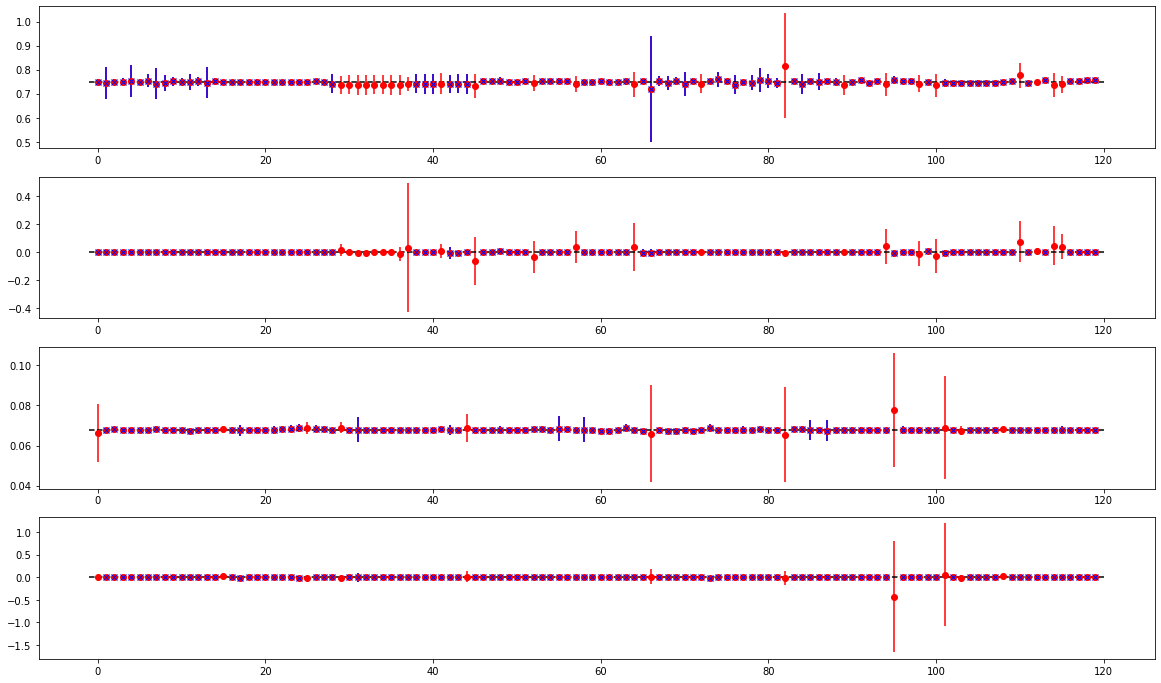

In [47]:
# Plot all combinations (red) and indicate selected (blue) for a selected location
# Note, 'HEAD' and 'TAIL' locations should not be used
# Change probe value

probe = 28

index = torch.arange(max(twiss.limit)*(2*max(twiss.limit) - 1), device=device)

bx, sigma_bx = twiss.data_phase['bx'][probe], twiss.data_phase['sigma_bx'][probe]
ax, sigma_ax = twiss.data_phase['ax'][probe], twiss.data_phase['sigma_ax'][probe]

by, sigma_by = twiss.data_phase['by'][probe], twiss.data_phase['sigma_by'][probe]
ay, sigma_ay = twiss.data_phase['ay'][probe], twiss.data_phase['sigma_ay'][probe]

plt.figure(figsize=(20, 3*4))

# bx
ax1 = plt.subplot(411)
ax1.errorbar(index.cpu().numpy(), bx.cpu().numpy(), yerr=sigma_bx.cpu().numpy(), fmt=' ', color='red', marker='o')
ax1.errorbar(index[mask_x[probe]].cpu().numpy(), bx[mask_x[probe]].cpu().numpy(), yerr=sigma_bx[mask_x[probe]].cpu().numpy(), fmt=' ', color='blue', marker='x')
ax1.hlines(model.bx[probe].cpu().numpy(), -1, len(index), color='black', linestyles='dashed')

# ax
ax2 = plt.subplot(412)
ax2.errorbar(index.cpu().numpy(), ax.cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', color='red', marker='o')
ax2.errorbar(index[mask_x[probe]].cpu().numpy(), ax[mask_x[probe]].cpu().numpy(), yerr=sigma_ax[mask_x[probe]].cpu().numpy(), fmt=' ', color='blue', marker='x')
ax2.hlines(model.ax[probe].cpu().numpy(), -1, len(index), color='black', linestyles='dashed')

# by
ax3 = plt.subplot(413)
ax3.errorbar(index.cpu().numpy(), by.cpu().numpy(), yerr=sigma_by.cpu().numpy(), fmt=' ', color='red', marker='o')
ax3.errorbar(index[mask_y[probe]].cpu().numpy(), by[mask_y[probe]].cpu().numpy(), yerr=sigma_by[mask_y[probe]].cpu().numpy(), fmt=' ', color='blue', marker='x')
ax3.hlines(model.by[probe].cpu().numpy(), -1, len(index), color='black', linestyles='dashed')

# ay
ax4 = plt.subplot(414)
ax4.errorbar(index.cpu().numpy(), ay.cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', color='red', marker='o')
ax4.errorbar(index[mask_y[probe]].cpu().numpy(), ay[mask_y[probe]].cpu().numpy(), yerr=sigma_ay[mask_y[probe]].cpu().numpy(), fmt=' ', color='blue', marker='x')
ax4.hlines(model.ay[probe].cpu().numpy(), -1, len(index), color='black', linestyles='dashed')

plt.show()

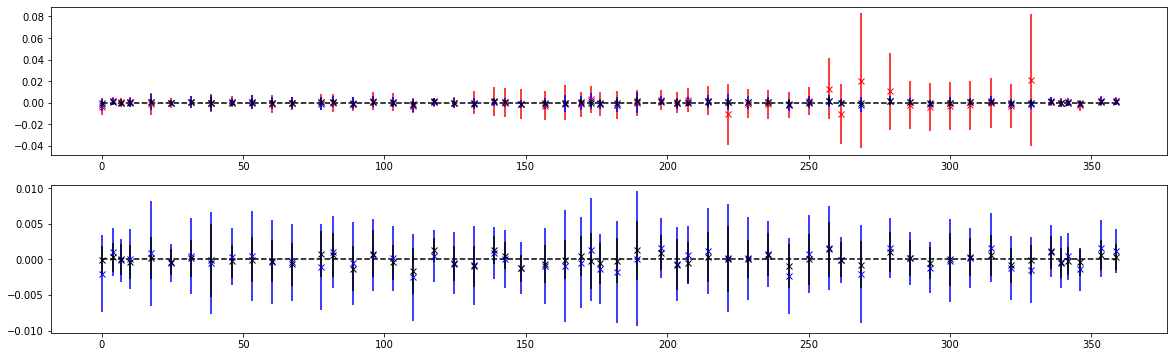

(bx_m - bx_1)[1:-1].abs().sum().item()=  1.28849341
(bx_m - bx_2)[1:-1].abs().sum().item()=  0.56624851
(bx_m - bx_3)[1:-1].abs().sum().item()= 0.262792639



In [48]:
# Twiss data processing can be performed with process_twiss method
# This method returns the result as a dictionary
# dict_keys(['value_a', 'sigma_a', 'error_a', 'value_b', 'sigma_b', 'error_b'])
# And updates self.ax, self.bx, self.ay, self.by and corresponding errors
# Processing is done for one plane ('x' or 'y') at a time

# This method uses weighted estimator for center and spread
# If weight is True, estimated errors for each combinations are used as weights
# If mask is provided, it is used as weights (weight is False) or weights are multiplied by given mask (weight is True)
# Combinations with False values thus have zero weight

# Compare different processing options

# No filtering or weights

out1 = twiss.process_twiss(plane='x', mask=None, weight=False)

# Filter mask is used as weights

out2 = twiss.process_twiss(plane='x', mask=mask_x, weight=False)

# Weights for each combitations are multiplied by filter mask

out3 = twiss.process_twiss(plane='x', mask=mask_x, weight=True)

bx_m = twiss.model.bx

bx_1, sigma_bx_1 = out1['value_b'], out1['sigma_b']
bx_2, sigma_bx_2 = out2['value_b'], out2['sigma_b']
bx_3, sigma_bx_3 = out3['value_b'], out3['sigma_b']

# red - 1, blue - 2, black - 3

plt.figure(figsize=(20, 3*2))

# 1 & 2 & 3
ax1 = plt.subplot(211)
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), ((bx_m - bx_1)/bx_m)[1:-1].cpu().numpy(), yerr=(sigma_bx_1/bx_m)[1:-1].cpu().numpy(), fmt=' ', marker='x', color='red')
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), ((bx_m - bx_2)/bx_m)[1:-1].cpu().numpy(), yerr=(sigma_bx_2/bx_m)[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), ((bx_m - bx_3)/bx_m)[1:-1].cpu().numpy(), yerr=(sigma_bx_3/bx_m)[1:-1].cpu().numpy(), fmt=' ', marker='x', color='black')
ax1.hlines(0, twiss.model.time[1:-1].cpu().numpy().min(), twiss.model.time[1:-1].cpu().numpy().max(), color='black', linestyles='dashed')

# 2 & 3
ax2 = plt.subplot(212)
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), ((bx_m - bx_2)/bx_m)[1:-1].cpu().numpy(), yerr=(sigma_bx_2/bx_m)[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), ((bx_m - bx_3)/bx_m)[1:-1].cpu().numpy(), yerr=(sigma_bx_3/bx_m)[1:-1].cpu().numpy(), fmt=' ', marker='x', color='black')
ax2.hlines(0, twiss.model.time[1:-1].cpu().numpy().min(), twiss.model.time[1:-1].cpu().numpy().max(), color='black', linestyles='dashed')

plt.show()

print(f'{(bx_m - bx_1)[1:-1].abs().sum().item()=:12.9}')
print(f'{(bx_m - bx_2)[1:-1].abs().sum().item()=:12.9}')
print(f'{(bx_m - bx_3)[1:-1].abs().sum().item()=:12.9}')
print()

In [49]:
# Compare different cases of twiss computation

# 1 -- from amplitude
# 2 -- from phase (range limit)
# 3 -- from phase (range limit & correction)

twiss = Twiss(model, table, limit=8)
twiss.phase_virtual()
twiss.phase_correct(use_probe=True)

# Uncorrected 

twiss.get_twiss_from_phase()
mask_x = twiss.filter_twiss(plane='x')
mask_y = twiss.filter_twiss(plane='y')
_ = twiss.process_twiss(plane='x', mask=mask_x, weight=True)
_ = twiss.process_twiss(plane='y', mask=mask_y, weight=True)

ax_f_combo, sigma_ax_f_combo = torch.clone(twiss.ax), torch.clone(twiss.sigma_ax)
bx_f_combo, sigma_bx_f_combo = torch.clone(twiss.bx), torch.clone(twiss.sigma_bx)
ay_f_combo, sigma_ay_f_combo = torch.clone(twiss.ay), torch.clone(twiss.sigma_ay)
by_f_combo, sigma_by_f_combo = torch.clone(twiss.by), torch.clone(twiss.sigma_by)

# Corrected

twiss.get_twiss_from_phase(use_correct=True)
mask_x = twiss.filter_twiss(plane='x')
mask_y = twiss.filter_twiss(plane='y')
_ = twiss.process_twiss(plane='x', mask=mask_x, weight=True)
_ = twiss.process_twiss(plane='y', mask=mask_y, weight=True)

ax_f_correct, sigma_ax_f_correct = torch.clone(twiss.ax), torch.clone(twiss.sigma_ax)
bx_f_correct, sigma_bx_f_correct = torch.clone(twiss.bx), torch.clone(twiss.sigma_bx)
ay_f_correct, sigma_ay_f_correct = torch.clone(twiss.ay), torch.clone(twiss.sigma_ay)
by_f_correct, sigma_by_f_correct = torch.clone(twiss.by), torch.clone(twiss.sigma_by)

(bx_m[twiss.model.monitor_index] - bx_a).abs().sum().item()=  0.60225193
(by_m[twiss.model.monitor_index] - by_a).abs().sum().item()=  1.22923891

(bx_m - bx_f)[1:-1].abs().sum().item()=  1.32910315
(by_m - by_f)[1:-1].abs().sum().item()=  4.77881371

(bx_m - bx_f_combo)[1:-1].abs().sum().item()= 0.262792639
(by_m - by_f_combo)[1:-1].abs().sum().item()= 0.298603875

(bx_m - bx_f_correct)[1:-1].abs().sum().item()= 0.041340114
(by_m - by_f_correct)[1:-1].abs().sum().item()=0.0612066158



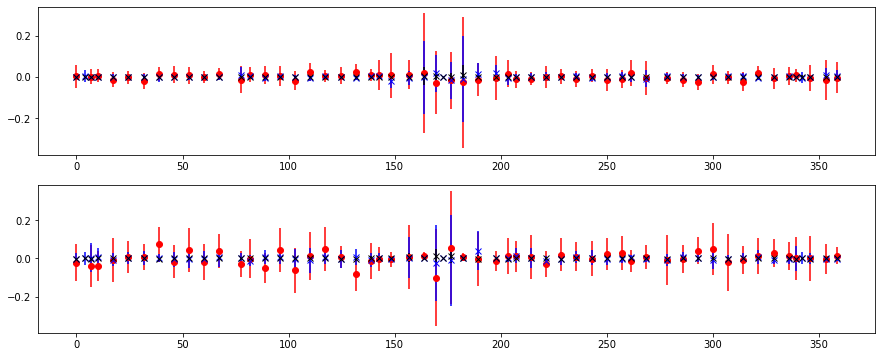

In [50]:
# Plot twiss beta results ('HEAD' and 'TAIL' virtual locations are dropped)
# Note, relative error is plotted

# Model

bx_m, by_m = twiss.model.bx, twiss.model.by

print(f'{(bx_m[twiss.model.monitor_index] - bx_a).abs().sum().item()=:12.9}')
print(f'{(by_m[twiss.model.monitor_index] - by_a).abs().sum().item()=:12.9}')
print()

print(f'{(bx_m - bx_f)[1:-1].abs().sum().item()=:12.9}')
print(f'{(by_m - by_f)[1:-1].abs().sum().item()=:12.9}')
print()

print(f'{(bx_m - bx_f_combo)[1:-1].abs().sum().item()=:12.9}')
print(f'{(by_m - by_f_combo)[1:-1].abs().sum().item()=:12.9}')
print()

print(f'{(bx_m - bx_f_correct)[1:-1].abs().sum().item()=:12.9}')
print(f'{(by_m - by_f_correct)[1:-1].abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (bx_m[twiss.model.monitor_index] - bx_a).cpu().numpy(), yerr=sigma_bx_a.cpu().numpy(), fmt=' ', marker='o', color='red')
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), (bx_m - bx_f_combo)[1:-1].cpu().numpy(), yerr=sigma_bx_f_combo[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), (bx_m - bx_f_correct)[1:-1].cpu().numpy(), yerr=sigma_bx_f_correct[1:-1].cpu().numpy(), fmt=' ', marker='x', color='black')

ax2 = plt.subplot(212)
ax2.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (by_m[twiss.model.monitor_index] - by_a).cpu().numpy(), yerr=sigma_by_a.cpu().numpy(), fmt=' ', marker='o', color='red')
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), (by_m - by_f_combo)[1:-1].cpu().numpy(), yerr=sigma_by_f_combo[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), (by_m - by_f_correct)[1:-1].cpu().numpy(), yerr=sigma_by_f_correct[1:-1].cpu().numpy(), fmt=' ', marker='x', color='black')

plt.show()

(ax_m - ax_f)[1:-1].abs().sum().item()= 0.380917759
(ay_m - ay_f)[1:-1].abs().sum().item()=  1.43737024

(ax_m - ax_f_combo)[1:-1].abs().sum().item()=0.0932020719
(ay_m - ay_f_combo)[1:-1].abs().sum().item()= 0.104890506

(ax_m - ax_f_correct)[1:-1].abs().sum().item()=0.0117982357
(ay_m - ay_f_correct)[1:-1].abs().sum().item()= 0.019408636



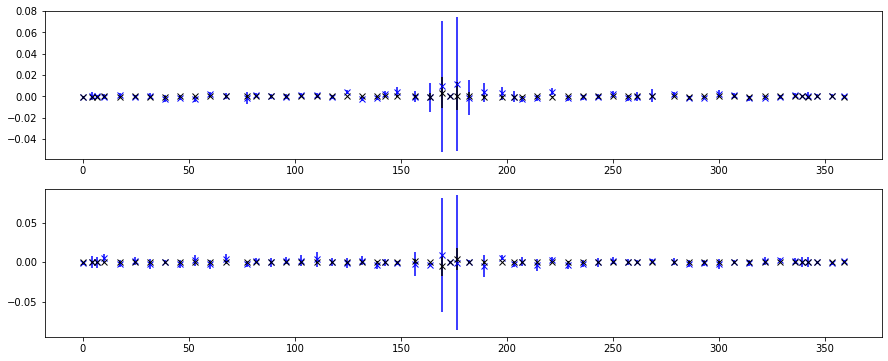

In [51]:
# Plot twiss alpha results ('HEAD' and 'TAIL' virtual locations are dropped)
# Note, relative error is plotted

# Model

ax_m, ay_m = twiss.model.ax, twiss.model.ay

print(f'{(ax_m - ax_f)[1:-1].abs().sum().item()=:12.9}')
print(f'{(ay_m - ay_f)[1:-1].abs().sum().item()=:12.9}')
print()

print(f'{(ax_m - ax_f_combo)[1:-1].abs().sum().item()=:12.9}')
print(f'{(ay_m - ay_f_combo)[1:-1].abs().sum().item()=:12.9}')
print()

print(f'{(ax_m - ax_f_correct)[1:-1].abs().sum().item()=:12.9}')
print(f'{(ay_m - ay_f_correct)[1:-1].abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), (ax_m - ax_f_combo)[1:-1].cpu().numpy(), yerr=sigma_ax_f_combo[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), (ax_m - ax_f_correct)[1:-1].cpu().numpy(), yerr=sigma_ax_f_correct[1:-1].cpu().numpy(), fmt=' ', marker='x', color='black')

ax2 = plt.subplot(212)
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), (ay_m - ay_f_combo)[1:-1].cpu().numpy(), yerr=sigma_ay_f_combo[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), (ay_m - ay_f_correct)[1:-1].cpu().numpy(), yerr=sigma_ay_f_correct[1:-1].cpu().numpy(), fmt=' ', marker='x', color='black')

plt.show()

In [52]:
# Using several combinations can significanty impove twiss estimation accuracy based on phase data
# In this example random noise is the only error source
# Since signals are generated using the model, phase correction improves accuracy significantly in this case

# Example-05: Default twiss (__call__ method)

In [53]:
# Compute reference parameters (frequency, amplitude and phase)

df = pandas.read_pickle('../virtual_tbt.pkl.gz')

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, torch.tensor(df.X.to_list(), dtype=dtype, device=device))
y = Data.from_data(w, torch.tensor(df.Y.to_list(), dtype=dtype, device=device))

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [54]:
# Set noise

noise_x = 1.0E-6*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-6*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

In [55]:
# Compute frequency, amplitude and phase for x plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=64, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=256, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

nux= 0.536883167, sigma_nux=6.31374899e-07, error_nux=6.82653851e-08

(ax - ref_ax).abs().sum().item()=0.000109722884

(fx - ref_fx).abs().sum().item()=0.0359434895



In [56]:
# Compute frequency, amplitude and phase for y plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=64, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=256, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

nuy= 0.576774699, sigma_nuy=6.84732257e-07, error_nuy=6.60059937e-08

(ay - ref_ay).abs().sum().item()=8.61574085e-05

(fy - ref_fy).abs().sum().item()=0.0403511545



In [57]:
# Set model & table

model = Model(path='../config.yaml', dtype=dtype, device=device)
table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

In [58]:
# Default twiss (compute action, beta from amplitude, virtual phase, corrected phase and twiss from phase)

twiss = Twiss(model, table, limit=8)
twiss()

,name,kind,flag,time,ax,sigma_ax,bx,sigma_bx,fx,sigma_fx,ay,sigma_ay,by,sigma_by,fy,sigma_fy
0,HEAD,VIRTUAL,0,0.000000,-0.678284,0.001562,7.466125,0.015041,0.595478,0.000741,0.653777,0.002089,15.838493,0.034216,-0.580202,0.000977
1,STP2,MONITOR,1,0.000000,-0.678049,0.001567,7.465072,0.014042,0.595326,0.004508,0.655372,0.002205,15.835618,0.043421,-0.581171,0.005166
2,IV4P,VIRTUAL,0,4.153500,1.953892,0.003495,14.231077,0.026712,0.981353,0.000725,-2.758974,0.007523,13.849738,0.036131,-0.276465,0.000976
3,STP4,MONITOR,1,6.667000,0.382733,0.001448,3.122704,0.007762,1.432602,0.004452,3.091696,0.007779,30.430538,0.079518,-0.173149,0.005078
4,SRP1,MONITOR,1,10.190565,-0.803182,0.001960,4.737760,0.012068,2.561392,0.004589,1.839270,0.004372,13.266905,0.034659,0.002148,0.005022
5,SRP2,MONITOR,1,17.337624,-0.718318,0.001876,4.556422,0.009562,-2.624175,0.004481,1.842132,0.003698,13.284298,0.029342,0.794359,0.004976
6,SRP3,MONITOR,1,24.484683,-0.770323,0.001524,4.484107,0.008308,-1.466069,0.004369,1.847052,0.005151,13.327305,0.035057,1.587313,0.004996
7,SRP4,MONITOR,1,31.631742,-0.788445,0.001080,4.757334,0.008560,-0.354703,0.004442,1.844670,0.006110,13.297098,0.042325,2.379015,0.005067
8,SRP5,MONITOR,1,38.778801,-0.715311,0.001608,4.487228,0.008454,0.756198,0.004622,1.839187,0.005326,13.269167,0.039035,-3.111170,0.005060
9,SRP6,MONITOR,1,45.925860,-0.786844,0.002623,4.553330,0.013861,1.911979,0.004536,1.837390,0.003898,13.285211,0.027513,-2.316488,0.005188


In [59]:
# Get twiss parameter by index/name

print(twiss.get_ax(28))
print(twiss.get_ax('IP'))

tensor([-3.736450215582e-04, 6.695949350815e-04], dtype=torch.float64)
tensor([-3.736450215582e-04, 6.695949350815e-04], dtype=torch.float64)


In [60]:
# Get all twiss parameters by index/name

for key, value in twiss.get_twiss(28).items():
    print(f'{key:12.9}: {value.item():12.9}')
else:
    print()
    
for key, value in twiss.get_twiss('IP').items():
    print(f'{key:12.9}: {value.item():12.9}')
else:
    print()

ax          : -0.000373645022
sigma_ax    : 0.000669594935
bx          :   0.75074538
sigma_bx    : 0.00158442146
fx          :   1.02048485
sigma_fx    : 0.000685314463
ay          : -0.000163328142
sigma_ay    : 0.00105769078
by          : 0.0677433932
sigma_by    : 0.000171975318
fy          :   3.10006307
sigma_fy    : 0.00110383659

ax          : -0.000373645022
sigma_ax    : 0.000669594935
bx          :   0.75074538
sigma_bx    : 0.00158442146
fx          :   1.02048485
sigma_fx    : 0.000685314463
ay          : -0.000163328142
sigma_ay    : 0.00105769078
by          : 0.0677433932
sigma_by    : 0.000171975318
fy          :   3.10006307
sigma_fy    : 0.00110383659



# Example-06: Twiss from phase data (precomputed model & weight mask)

In [61]:
# Compute reference parameters (frequency, amplitude and phase)

df = pandas.read_pickle('../virtual_tbt.pkl.gz')

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, torch.tensor(df.X.to_list(), dtype=dtype, device=device))
y = Data.from_data(w, torch.tensor(df.Y.to_list(), dtype=dtype, device=device))

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [62]:
# Set noise

noise_x = 1.0E-6*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-6*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

In [63]:
# Compute frequency, amplitude and phase for x plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=64, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=256, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

nux= 0.536883177, sigma_nux=5.32596077e-07, error_nux=7.79977691e-08

(ax - ref_ax).abs().sum().item()=9.01806318e-05

(fx - ref_fx).abs().sum().item()=0.0405976909



In [64]:
# Compute frequency, amplitude and phase for y plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=64, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=256, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

nuy= 0.576774658, sigma_nuy=7.12936192e-07, error_nuy=2.46236531e-08

(ay - ref_ay).abs().sum().item()=0.000100581081

(fy - ref_fy).abs().sum().item()=0.0377102855



In [65]:
# Set model & table
# If limit is passed, model phase advance data is computed

model = Model(path='../config.yaml', limit=8, dtype=dtype, device=device)
table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

In [66]:
# Set twiss
# Keep combinations with distance 2, 3 and 4
# Note, with get_twiss_from_phase(use_model=True), precomputed model phase advance is used

twiss = Twiss(model, table, limit=(1, 4), use_model=True)
print(model.combo.shape)
print(twiss.combo.shape)

torch.Size([59, 120, 2, 2])
torch.Size([59, 27, 2, 2])


In [67]:
# Set twiss with external flags
# External flags can be used to mark monitors with anomalies
# If flag is passed, mask for all combinations is generated with zero weight for combinations having marked locations as other
# This mask can be used for twiss processing

flag = torch.clone(model.flag)
flag[10] = 0

twiss = Twiss(model, table, limit=1, use_model=True, flag=flag)
print(twiss.mask.shape)

# Print removed combinations

print((twiss.combo.flatten(1)[twiss.mask.flatten().logical_not()]).reshape(-1, 2, 2))

torch.Size([59, 1])
tensor([[[ 9,  8],
         [ 9, 10]],

        [[11, 10],
         [11, 12]]])


In [68]:
# This mask can be generated with mask_location method

mask = twiss.mask_location([10])
print(mask.shape)

# Print removed combinations

print((twiss.combo.flatten(1)[mask.flatten().logical_not()]).reshape(-1, 2, 2))

torch.Size([59, 1])
tensor([[[ 9,  8],
         [ 9, 10]],

        [[11, 10],
         [11, 12]]])


In [69]:
# Mask based on limit range

# Set twiss

twiss = Twiss(model, table, limit=2, use_model=True)

# Generate mask with zeros for limit one

mask, *_ = twiss.mask_range((1, 2))
print(mask)

# Generate mask with zeros for limit two

mask, *_ = twiss.mask_range((1, 1))
print(mask)

tensor([0, 1, 1, 1, 1, 1])
tensor([1, 0, 0, 0, 0, 0])


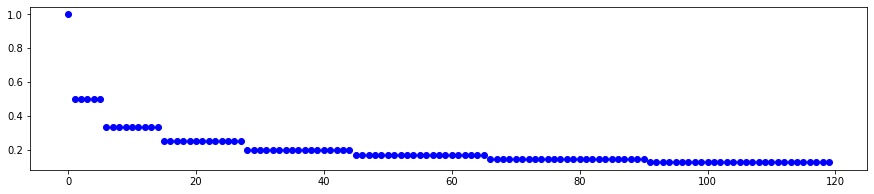

In [70]:
# Mask based on distance

# Set twiss

twiss = Twiss(model, table, limit=8, use_model=True)

# Generate mask

mask, *_ = twiss.mask_distance(lambda x: 1/x)

# Plot weights

plt.figure(figsize=(15, 3))
plt.scatter(range(len(mask)), mask.cpu().numpy(), color='blue')
plt.show()

# DEV-1: TEXT INSIDE

In [15]:
# Import

import epics
import numpy
import pandas
import torch
import nufft
import yaml

import sys
sys.path.append('..')

from harmonica.util import LIMIT, mod, generate_pairs
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition
from harmonica.model import Model
from harmonica.table import Table
from harmonica.twiss import Twiss

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [16]:
# Set data type and device
dtype = torch.float64
device = 'cpu'

In [17]:
# NOTE: BIAS
# SINCE BIAS IS THE SAME, ADVANCE HAS NO BIAS!!!!!!!!!!!!!!!!

# NOTE: NEED TO CHECK WHEN SIGNALS ARE GENERATED FROM MODEL WITH ERRORS

# TODO:
# generate matrix from i to j from measured or model (method)
# generate one-turn matrix from measured or model (method)

# NOTE: DATA CLENING AS A METHOD ACTING ON DICTIONARY
# 1. copy all data
# 2. set cleaned
# 3. operate on cleaned

# TODO:
# need generation of data, errors as thin quadrupoles? 

In [4]:
# 1. load model
# 2. get parameters (frequency, amplitude and phase), filtering, noise estimation, anomaly, synchronization, virtual, improved, etc

# NOTE: virtual and improved are computed inside TWISS? YES

# 3. have frequency, amplitude and phase (+ errors)

# 4. beta from amplitude (action estimation with mean/fit, outliers in action, weights by estimated noise, amplitude error)
#    (optics & errors)

# 5. beta from phase (monitor + virtual)
# set probe, set limit, find pair, triplets, compute alpha, beta and advance (can be 'improved') and errors
# clean by advance, cot, model threashhold, sigma threashold, dbscan in alpha/beta
# mean, std or weighted fit

# 6. beta from phase SVD/ODR

# 7. coupled optics SVD/ODR + synplectification

# 8. invariant fit (optics, invariant, error localization) (linear, coupled, nonlinear)

# 9. momentum (linear or gen functions)
# pair, many -> trj, complex dec, fit trj to inv

# 10. map, one turn map from data fit (x, px from many + measured model), symplectification, n-turn maps, sector maps

# 11. anomaly detector/auto

# 12. Super DMD/auto

# 13. responce matrix

# 14. correction POWEL DOGLEG BO\GP SIMPLEX + RSCA (see school) REENFOR? 
# responce: orbit, advance, beta, tune, ...

# 15. coupling correction, mean spectra, n-turn, dispersion, ...

In [5]:
# REF

df = pandas.read_pickle('../virtual_tbt.pkl.gz')

data = torch.tensor(df.X.to_list(), dtype=dtype, device=device)
length = 4096
w = Window(length, 'cosine_window', 5.0, dtype=dtype, device=device)
d = Data.from_data(w, data)
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency
h = Decomposition(d)
result, _ = h.harmonic_sum(frequency, w.window, d.data)
_, _, amplitude_x, phase_x = result.T

data = torch.tensor(df.Y.to_list(), dtype=dtype, device=device)
length = 4096
w = Window(length, 'cosine_window', 5.0, dtype=dtype, device=device)
d = Data.from_data(w, data)
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency
h = Decomposition(d)
result, _ = h.harmonic_sum(frequency, w.window, d.data)
_, _, amplitude_y, phase_y = result.T

In [6]:
noise_x = 1.0E-6
noise_y = 1.0E-6

nux= 0.536883099, sigma_nux=1.72871682e-16
nux= 0.536882977, sigma_nux=9.34516187e-07


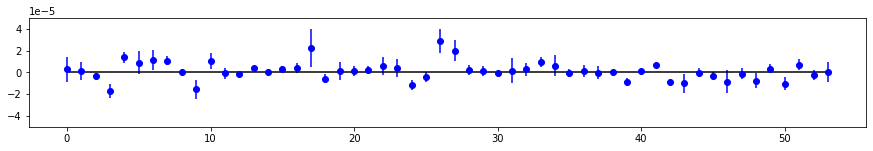

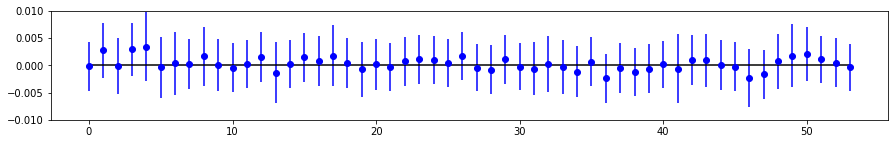

In [7]:
# X

df = pandas.read_pickle('../virtual_tbt.pkl.gz')
data = torch.tensor(df.X.to_list(), dtype=dtype, device=device)

# Reference parameters
length = 4096
w = Window(length, 'cosine_window', 5.0, dtype=dtype, device=device)
d = Data.from_data(w, data)
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency
h = Decomposition(d)
result, _ = h.harmonic_sum(frequency, w.window, d.data)
_, _, ref_ax, ref_fx = result.T
print(f'nux={frequency.item():12.9}, sigma_nux={spread.item():12.9}')

# Frequency
length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, data[:, :length])
n = noise_x*(25.0 + 75.0*torch.rand(54, dtype=dtype, device=device))
d.add_noise(n)
d.data.copy_(d.work)
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = f.frequency.mean(), f.frequency.std()
nux = 1.0 - nux
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}')

# Amplitude
dec = Decomposition(d)
ax, sigma_ax, _ = dec.harmonic_amplitude(nux, length=128, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=128, step=1, method='noise')
plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (ax - ref_ax).cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-5, +5.0E-5)
plt.show()

# Phase
fx, sigma_fx, _ = dec.harmonic_phase(nux, length=256, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=4, method='noise')
plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (fx - ref_fx).cpu().numpy(), yerr=sigma_fx.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

nuy= 0.576774633, sigma_nuy=1.82523846e-16
nuy= 0.576774584, sigma_nuy=1.26698238e-06


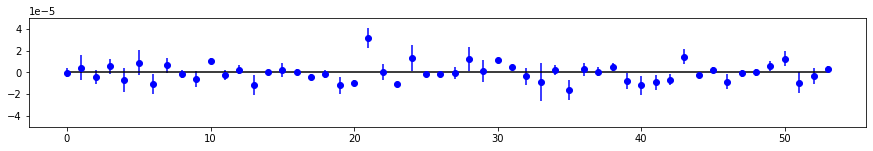

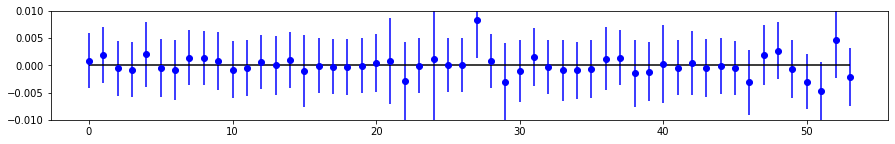

In [8]:
# Y

df = pandas.read_pickle('../virtual_tbt.pkl.gz')
data = torch.tensor(df.Y.to_list(), dtype=dtype, device=device)

# Reference parameters
length = 4096
w = Window(length, 'cosine_window', 5.0, dtype=dtype, device=device)
d = Data.from_data(w, data)
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency
h = Decomposition(d)
result, _ = h.harmonic_sum(frequency, w.window, d.data)
_, _, ref_ay, ref_fy = result.T
print(f'nuy={frequency.item():12.9}, sigma_nuy={spread.item():12.9}')

# Frequency
length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, data[:, :length])
n = noise_y*(25.0 + 75.0*torch.rand(54, dtype=dtype, device=device))
d.add_noise(n)
d.data.copy_(d.work)
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = f.frequency.mean(), f.frequency.std()
nuy = 1.0 - nuy
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}')

# Amplitude
dec = Decomposition(d)
ay, sigma_ay, _ = dec.harmonic_amplitude(nuy, length=128, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=128, step=1, method='noise')
plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (ay - ref_ay).cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-5, +5.0E-5)
plt.show()

# Phase
fy, sigma_fy, _ = dec.harmonic_phase(nuy, length=256, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=4, method='noise')
plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (fy - ref_fy).cpu().numpy(), yerr=sigma_fy.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

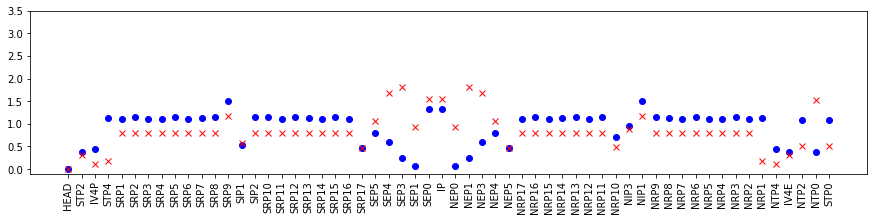

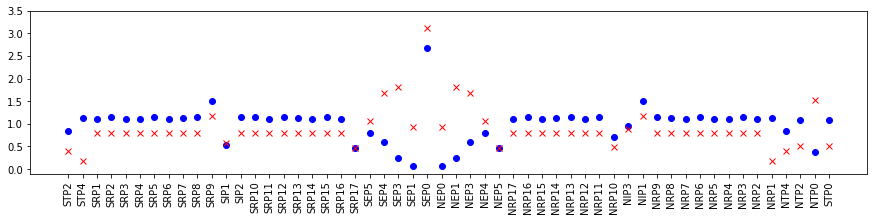

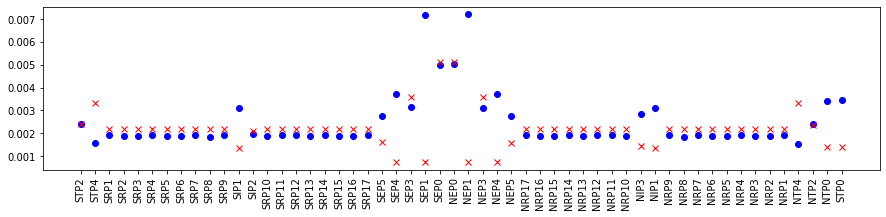

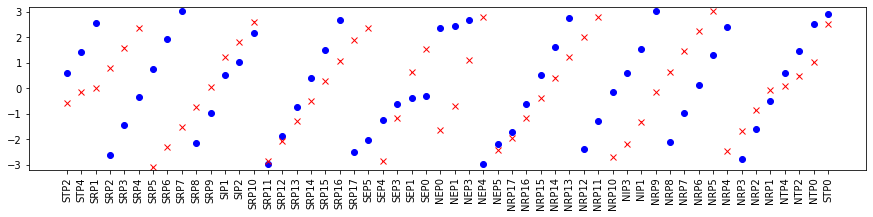

In [9]:
model = Model(path='../config.yaml', dtype=dtype, device=device)
name = [name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR']
table = Table(name, nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

plt.figure(figsize=(15, 3))
plt.errorbar(range(model.size - 1), model.phase_x[:-1].cpu().numpy(), yerr=model.sigma_x[:-1].cpu().numpy(), fmt=' ', color='blue', marker='o')
plt.errorbar(range(model.size - 1), model.phase_y[:-1].cpu().numpy(), yerr=model.sigma_y[:-1].cpu().numpy(), fmt=' ', color='red', marker='x')
plt.xticks(range(model.size - 1), model.name[:-1])
locs, labs = plt.xticks()
plt.setp(labs, rotation=90)
plt.ylim(-0.1, 3.5)
plt.show()

plt.figure(figsize=(15, 3))
plt.errorbar(range(model.monitor_count), model.monitor_phase_x.cpu().numpy(), yerr=model.monitor_sigma_x.cpu().numpy(), fmt=' ', color='blue', marker='o')
plt.errorbar(range(model.monitor_count), model.monitor_phase_y.cpu().numpy(), yerr=model.monitor_sigma_y.cpu().numpy(), fmt=' ', color='red', marker='x')
plt.xticks(range(model.monitor_count), name)
locs, labs = plt.xticks()
plt.setp(labs, rotation=90)
plt.ylim(-0.1, 3.5)
plt.show()

plt.figure(figsize=(15, 3))
plt.errorbar(range(table.size), table.ax.cpu().numpy(), yerr=table.sigma_ax.cpu().numpy(), fmt=' ', color='blue', marker='o')
plt.errorbar(range(table.size), table.ay.cpu().numpy(), yerr=table.sigma_ay.cpu().numpy(), fmt=' ', color='red', marker='x')
plt.xticks(range(table.size), name)
locs, labs = plt.xticks()
plt.setp(labs, rotation=90)
plt.show()

plt.figure(figsize=(15, 3))
plt.errorbar(range(table.size), table.fx.cpu().numpy(), yerr=table.sigma_fx.cpu().numpy(), fmt=' ', color='blue', marker='o')
plt.errorbar(range(table.size), table.fy.cpu().numpy(), yerr=table.sigma_fy.cpu().numpy(), fmt=' ', color='red', marker='x')
plt.xticks(range(table.size), name)
locs, labs = plt.xticks()
plt.setp(labs, rotation=90)
plt.ylim(-3.2, +3.2)
plt.show()

In [10]:
import numpy
import torch

from collections import Counter
from joblib import Parallel, delayed
from statsmodels.api import OLS, WLS
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from harmonica.util import mod, generate_pairs
from harmonica.model import Model
from harmonica.table import Table

class Twiss():
        
    def __init__(self, model:'Model', table:'Table', limit:int=8) -> None:
        """
        Twiss instance initialization.

        Parameters
        ----------
        model: 'Model'
            Model instance
        table: 'Table'
            Table instance
        limit: int
            range limit

        Returns
        -------
        None

        """
        self.model, self.table, self.limit = model, table, limit
        
        self.dtype, self.device = self.model.dtype, self.model.device
        
        if self.model.monitor_count != self.table.size:
            raise Exception(f'TWISS: expected {self.model.monitor_count} monitors in Model, got {self.table.size} in Table')
            
        if self.model.monitor_name != self.table.name:
            raise Exception(f'TWISS: expected monitor names to match')
            
        self.flag = [flag if kind == self.model._monitor else 0 for flag, kind in zip(self.model.flag, self.model.kind)]
        self.flag = torch.tensor(self.flag, dtype=torch.int64, device=self.device)
        
        self.data = [generate_other(probe, self.limit, self.flag) for probe in range(self.model.size)]
        self.pair = [generate_pairs(self.limit, 1 + 1, probe=probe, table=table) for probe, table in enumerate(self.data)]
        
        self.data = torch.tensor(self.data, dtype=torch.int64, device=self.device)
        self.pair = torch.tensor(self.pair, dtype=torch.int64, device=self.device)
        
        self.fx = torch.zeros_like(self.model.fx)
        self.fy = torch.zeros_like(self.model.fy)
        
        self.fx[self.model.monitor_index] = self.table.fx
        self.fy[self.model.monitor_index] = self.table.fy
        
        self.sigma_fx = torch.zeros_like(self.model.sigma_fx)
        self.sigma_fy = torch.zeros_like(self.model.sigma_fy)
        
        self.sigma_fx[self.model.monitor_index] = self.table.sigma_fx
        self.sigma_fy[self.model.monitor_index] = self.table.sigma_fy
        
        self.fx_correct, self.sigma_fx_correct = torch.clone(self.fx), torch.clone(self.sigma_fx)
        self.fy_correct, self.sigma_fy_correct = torch.clone(self.fy), torch.clone(self.sigma_fy)
        
        self.virtual_x, self.correct_x = {}, {}
        self.virtual_y, self.correct_y = {}, {}
        
        self.action, self.data_amplitude, self.data_phase = {}, {}, {}
        
        self.ax, self.sigma_ax = torch.zeros_like(self.model.ax), torch.zeros_like(self.model.sigma_ax)
        self.bx, self.sigma_bx = torch.zeros_like(self.model.bx), torch.zeros_like(self.model.sigma_bx)
        
        self.ay, self.sigma_ay = torch.zeros_like(self.model.ay), torch.zeros_like(self.model.sigma_ay)
        self.by, self.sigma_by = torch.zeros_like(self.model.by), torch.zeros_like(self.model.sigma_by)


    def get_action(self, *,
                   data_threshold:dict={'use': True, 'factor': 5.0},
                   data_dbscan:dict={'use': False, 'factor': 2.5},
                   data_local_outlier_factor:dict={'use': False, 'contamination': 0.01},
                   data_isolation_forest:dict={'use': False, 'contamination': 0.01}) -> None:
        """
        Estimate actions with optional data cleaning and.
        Estimate actions center and spread.

        Parameters
        ----------
        data_threshold: dict
            parameters for threshold detector
        data_dbscan: dict
            parameters for dbscan detector
        data_local_outlier_factor: dict
            parameters for local outlier factor detector
        data_isolation_forest: dict
            parameters for isolation forest detector

        Returns
        -------
        None, update self.action dictionary

        """
        self.action = {}
        
        index = self.model.monitor_index
        
        jx = self.table.ax**2/(2.0*self.model.bx[index])
        jy = self.table.ay**2/(2.0*self.model.by[index])
        
        sigma_jx = self.table.ax/self.model.bx[index]*self.table.sigma_ax
        sigma_jy = self.table.ay/self.model.by[index]*self.table.sigma_ay
        
        mask = torch.clone(self.flag[index])
        mask = torch.stack([mask, mask]).to(torch.bool)
                
        data = standardize(torch.stack([jx, jy]), center_estimator=median, spread_estimator=biweight_midvariance)
        
        if data_threshold['use']:
            factor = data_threshold['factor']
            center = median(data)
            spread = biweight_midvariance(data).sqrt()
            min_value, max_value = center - factor*spread, center + factor*spread
            mask *= threshold(data, min_value, max_value)
            
        if data_dbscan['use']:
            factor = data_dbscan['factor']
            for case in range(1):
                mask[case] *= dbscan(data[case].reshape(-1, 1), epsilon=factor)
        
        if data_local_outlier_factor['use']:
            for case in range(1):
                mask[case] *= local_outlier_factor(data[case].reshape(-1, 1), contamination=data_local_outlier_factor['contamination'])
                
        if data_isolation_forest['use']:
            for case in range(1):
                mask[case] *= isolation_forest(data[case].reshape(-1, 1), contamination=data_isolation_forest['contamination'])
                
        mask_jx, mask_jy = mask
        mask_jx, mask_jy = mask_jx/sigma_jx**2, mask_jy/sigma_jy**2
                
        center_jx = weighted_mean(jx, weight=mask_jx)
        spread_jx = weighted_variance(jx, weight=mask_jx, center=center_jx).sqrt()
        
        center_jy = weighted_mean(jy, weight=mask_jy)
        spread_jy = weighted_variance(jy, weight=mask_jy, center=center_jy).sqrt()
        
        self.action['jx'], self.action['sigma_jx'] = jx, sigma_jx
        self.action['center_jx'], self.action['spread_jx'] = center_jx, spread_jx
        
        self.action['jy'], self.action['sigma_jy'] = jy, sigma_jy
        self.action['center_jy'], self.action['spread_jy'] = center_jy, spread_jy
        
        self.action['mask'] = mask
        
        
    def get_twiss_from_amplitude(self) -> None:
        """
        Estimate twiss from amplitude.

        Note, action data should be precomputed

        Parameters
        ----------
        None

        Returns
        -------
        None, update self.twiss_from_amplitude dictionary

        """
        if self.action == {}:
            raise Exception('error: action dictionary is empty')
        
        self.data_amplitude = {}
        
        ax, sigma_ax = self.table.ax, self.table.sigma_ax
        ay, sigma_ay = self.table.ay, self.table.sigma_ay
        
        jx, sigma_jx = self.action['center_jx'], self.action['spread_jx']
        jy, sigma_jy = self.action['center_jy'], self.action['spread_jy']
        
        bx, by = ax**2/(2.0*jx), ay**2/(2.0*jy)
        
        sigma_bx = torch.sqrt(ax**2/jx**2*sigma_ax**2 + 0.25*ax**4/jx**4*sigma_jx**2)
        sigma_by = torch.sqrt(ay**2/jy**2*sigma_ay**2 + 0.25*ay**4/jy**4*sigma_jy**2)
        
        index = self.model.monitor_index
        bx_model, by_model = self.model.bx[index], self.model.by[index]
        
        self.data_amplitude['bx'], self.data_amplitude['sigma_bx'] = bx, sigma_bx
        self.data_amplitude['by'], self.data_amplitude['sigma_by'] = by, sigma_by
        

    def phase_virtual(self, limit:int=None, exclude:list=None, **kwargs) -> None:
        """
        Estimate x & y phase for virtual locations.

        Parameters
        ----------
        limit: int
            range limit
        exclude: list
            list of virtual location to exclude
        **kwargs:
            passed to Decomposition.phase_virtual

        Returns
        -------
        None, update self.virtual_x and self.virtual_y dictionaries

        """        
        self.virtual_x, self.virtual_y = {}, {}
        
        limit = self.limit if limit is None else limit
        exclude = [] if exclude is None else exclude
        index = [index for index in self.model.virtual_index if index not in exclude]
        
        nux, sigma_nux = self.table.nux, self.table.sigma_nux
        NUX, sigma_NUX = self.model.nux, self.model.sigma_nux
        
        nuy, sigma_nuy = self.table.nuy, self.table.sigma_nuy
        NUY, sigma_NUY = self.model.nuy, self.model.sigma_nuy

        fx, sigma_fx = self.fx, self.sigma_fx
        FX, sigma_FX = self.model.fx, self.model.sigma_fx

        fy, sigma_fy = self.fy, self.sigma_fy
        FY, sigma_FY = self.model.fy, self.model.sigma_fy
        
        def auxiliary_x(probe):
            return Decomposition.phase_virtual(probe, limit, self.flag, nux, NUX, fx, FX,
                                                    sigma_frequency=sigma_nux, sigma_frequency_model=sigma_NUX,
                                                    sigma_phase=sigma_fx, sigma_phase_model=sigma_FX,
                                                    **kwargs)
        
        def auxiliary_y(probe):
            return Decomposition.phase_virtual(probe, limit, self.flag, nuy, NUY, fy, FY,
                                                    sigma_frequency=sigma_nuy, sigma_frequency_model=sigma_NUY,
                                                    sigma_phase=sigma_fy, sigma_phase_model=sigma_FY,
                                                    **kwargs)
        
        data_x = [auxiliary_x(probe) for probe in index]
        data_y = [auxiliary_y(probe) for probe in index]
        
        for count, probe in enumerate(index):
            self.virtual_x[probe], self.virtual_y[probe] = data_x[count], data_y[count]
            self.fx[probe], self.sigma_fx[probe] = self.virtual_x[probe].get('model')
            self.fy[probe], self.sigma_fy[probe] = self.virtual_y[probe].get('model')
            
            
    def phase_correct(self, *, limit:int=None, **kwargs) -> None:
        """
        Correct x & y phase for monitor locations.
        
        Note, this introduce strong bias towards model.

        Parameters
        ----------
        limit: int
            range limit
        **kwargs:
            passed to phase_virtual Decomposition method

        Returns
        -------
        None, update self.correct_x and self.correct_y dictionaries

        """
        self.correct_x, self.correct_y = {}, {}

        limit = self.limit if limit is None else limit
        index = self.model.monitor_index

        self.fx_correct, self.sigma_fx_correct = torch.clone(self.fx), torch.clone(self.sigma_fx)
        self.fy_correct, self.sigma_fy_correct = torch.clone(self.fy), torch.clone(self.sigma_fy)

        nux, sigma_nux = self.table.nux, self.table.sigma_nux
        NUX, sigma_NUX = self.model.nux, self.model.sigma_nux

        nuy, sigma_nuy = self.table.nuy, self.table.sigma_nuy
        NUY, sigma_NUY = self.model.nuy, self.model.sigma_nuy

        fx, sigma_fx = self.fx, self.sigma_fx
        FX, sigma_FX = self.model.fx, self.model.sigma_fx

        fy, sigma_fy = self.fy, self.sigma_fy
        FY, sigma_FY = self.model.fy, self.model.sigma_fy

        def auxiliary_x(probe):
            return Decomposition.phase_virtual(probe, limit, self.flag, nux, NUX, fx, FX,
                                                    sigma_frequency=sigma_nux, sigma_frequency_model=sigma_NUX,
                                                    sigma_phase=sigma_fx, sigma_phase_model=sigma_FX,
                                                    **kwargs)
        
        def auxiliary_y(probe):
            return Decomposition.phase_virtual(probe, limit, self.flag, nuy, NUY, fy, FY,
                                                    sigma_frequency=sigma_nuy, sigma_frequency_model=sigma_NUY,
                                                    sigma_phase=sigma_fy, sigma_phase_model=sigma_FY,
                                                    **kwargs)
        
        data_x = [auxiliary_x(probe) for probe in index]
        data_y = [auxiliary_y(probe) for probe in index]
        
        for count, probe in enumerate(index):
            self.correct_x[probe], self.correct_y[probe] = data_x[count], data_y[count]
            self.fx_correct[probe], self.sigma_fx_correct[probe] = self.correct_x[probe].get('model')
            self.fy_correct[probe], self.sigma_fy_correct[probe] = self.correct_y[probe].get('model')
            
            
    @staticmethod
    def phase_alfa(a_m:torch.Tensor,
                   f_ij:torch.Tensor, f_m_ij:torch.Tensor,
                   f_ik:torch.Tensor, f_m_ik:torch.Tensor,
                   *,
                   error:bool=True, model:bool=True,
                   sigma_a_m:torch.Tensor=0.0,
                   sigma_f_ij:torch.Tensor=0.0, sigma_f_m_ij:torch.Tensor=0.0,
                   sigma_f_ik:torch.Tensor=0.0, sigma_f_m_ik:torch.Tensor=0.0) -> tuple:
        """
        Estimate twiss alpha at location (i) from given triplet (i, j, k) phase data.

        Note, probed location (i), other locations (j) and (k)
        Phase advance is assumed to be from (i) to other locations, should be negative if (i) is ahead of the other location (timewise)

        Parameters
        ----------
        a_m: torch.Tensor
            model value
        f_ij: torch.Tensor
            phase advance between probed and 1st location
        f_m_ij: torch.Tensor
            model phase advance between probed and 1st location
        f_ik: torch.Tensor
            phase advance between probed and 2nd location
        f_m_ik: torch.Tensor
            model phase advance between probed and 2nd location
        error: bool
            flag to compute error
        model: bool
            flag to include model error
        sigma_a_m: torch.Tensor
            model value error
        sigma_f_ij: torch.Tensor
            phase advance error between probed and 1st location
        sigma_f_m_ij: torch.Tensor
            model phase advance error between probed and 1st location
        sigma_f_ik: torch.Tensor
            phase advance error between probed and 2nd location
        sigma_f_m_ik: torch.Tensor
            model phase advance error between probed and 2nd location

        Returns
        -------
        (a, None) or (a, sigma_a)

        """
        a = a_m*(1.0/torch.tan(f_ij)-1.0/torch.tan(f_ik))/(1.0/torch.tan(f_m_ij)-1.0/torch.tan(f_m_ik))-1.0/torch.tan(f_ij)*1.0/torch.sin(f_m_ij - f_m_ik)*torch.cos(f_m_ik)*torch.sin(f_m_ij) + 1.0/torch.tan(f_ik)*1.0/torch.sin(f_m_ij - f_m_ik)*torch.cos(f_m_ij)*torch.sin(f_m_ik)

        if not error:
            return (a, torch.zeros_like(a))

        sigma_a  = sigma_f_ij**2*(1.0/torch.sin(f_ij))**4*(1.0/torch.tan(f_m_ik) + a_m)**2/(1.0/torch.tan(f_m_ij) - 1.0/torch.tan(f_m_ik))**2
        sigma_a += sigma_f_ik**2*(1.0/torch.sin(f_ik))**4*(1.0/torch.tan(f_m_ij) + a_m)**2/(1.0/torch.tan(f_m_ij) - 1.0/torch.tan(f_m_ik))**2
        
        if model:
            sigma_a += sigma_a_m**2*((1.0/torch.tan(f_ij) - 1.0/torch.tan(f_ik))**2/(1.0/torch.tan(f_m_ij) - 1.0/torch.tan(f_m_ik))**2)
            sigma_a += sigma_f_m_ik**2*(1.0/torch.tan(f_ij) - 1.0/torch.tan(f_ik))**2*(1.0/torch.sin(f_m_ij - f_m_ik))**4*torch.sin(f_m_ij)**2*(torch.cos(f_m_ij) + a_m*torch.sin(f_m_ij))**2
            sigma_a += sigma_f_m_ij**2*(1.0/torch.tan(f_ij) - 1.0/torch.tan(f_ik))**2*(1.0/torch.sin(f_m_ij - f_m_ik))**4*torch.sin(f_m_ik)**2*(torch.cos(f_m_ik) + a_m*torch.sin(f_m_ik))**2

        sigma_a.sqrt_()
        return (a, sigma_a)


    @staticmethod
    def phase_beta(b_m:torch.Tensor,
                   f_ij:torch.Tensor, f_m_ij:torch.Tensor,
                   f_ik:torch.Tensor, f_m_ik:torch.Tensor,
                   *,
                   error:bool=True, model:bool=True,
                   sigma_b_m:torch.Tensor=0.0,
                   sigma_f_ij:torch.Tensor=0.0, sigma_f_m_ij:torch.Tensor=0.0,
                   sigma_f_ik:torch.Tensor=0.0, sigma_f_m_ik:torch.Tensor=0.0) -> tuple:
        """
        Estimate twiss beta at location (i) from given triplet (i, j, k) phase data.

        Note, probed location (i), other locations (j) and (k)
        Phase advance is assumed to be from (i) to other location, should be negative if (i) is ahead of the other location (timewise)

        Parameters
        ----------
        b_m: torch.Tensor
            model value
        f_ij: torch.Tensor
            phase advance between probed and 1st location
        f_m_ij: torch.Tensor
            model phase advance between probed and 1st location
        f_ik: torch.Tensor
            phase advance between probed and 2nd location
        f_m_ik: torch.Tensor
            model phase advance between probed and 2nd location
        error: bool
            flag to compute error
        model: bool
            flag to include model error
        sigma_b_m: torch.Tensor
            model value error
        sigma_f_ij: torch.Tensor
            phase advance error between probed and 1st location
        sigma_f_m_ij: torch.Tensor
            model phase advance error between probed and 1st location
        sigma_f_ik: torch.Tensor
            phase advance error between probed and 2nd location
        sigma_f_m_ik: torch.Tensor
            model phase advance error between probed and 2nd location

        Returns
        -------
        (b, None) or (b, sigma_b)

        """
        b = b_m*(1.0/torch.tan(f_ij) - 1.0/torch.tan(f_ik))/(1.0/torch.tan(f_m_ij) - 1.0/torch.tan(f_m_ik))

        if not error:
            return (b, torch.zeros_like(b))
        
        sigma_b  = sigma_f_ij**2*b_m**2*(1.0/torch.sin(f_ij))**4/(1.0/torch.tan(f_m_ij) - 1.0/torch.tan(f_m_ik))**2
        sigma_b += sigma_f_ik**2*b_m**2*(1.0/torch.sin(f_ik))**4/(1.0/torch.tan(f_m_ij) - 1.0/torch.tan(f_m_ik))**2
        
        if model:
            sigma_b += sigma_b_m**2*(1.0/torch.tan(f_ij) - 1.0/torch.tan(f_ik))**2/(1.0/torch.tan(f_m_ij) - 1.0/torch.tan(f_m_ik))**2
            sigma_b += sigma_f_m_ij**2*b_m**2*(1.0/torch.tan(f_ij) - 1.0/torch.tan(f_ik))**2*(1.0/torch.sin(f_m_ij))**4/(1.0/torch.tan(f_m_ij) - 1.0/torch.tan(f_m_ik))**4
            sigma_b += sigma_f_m_ik**2*b_m**2*(1.0/torch.tan(f_ij) - 1.0/torch.tan(f_ik))**2*(1.0/torch.sin(f_m_ik))**4/(1.0/torch.tan(f_m_ij) - 1.0/torch.tan(f_m_ik))**4

        sigma_b.sqrt_()
        return (b, sigma_b)
    
    
    def get_twiss_from_phase(self, *, virtual:bool=True, error:bool=True, model:bool=False,
                             use_correct:bool=False, use_correct_sigma:bool=False) -> None:
        """
        Estimate twiss from phase data.

        Note, raw data is saved, no cleaning is performed
        Values (and errors) are computed for each triplet

        Parameters
        ----------
        error: bool
            flag to compute twiss errors
        model: bool
            flag to include model error
        use_correct: bool
            flag to use corrected phases
        use_correct_sigma: bool
            flag to use corrected phase errors

        Returns
        -------
        None, update self.twiss_from_phase dictionary

        """
        self.data_phase = {}
        
        fx = self.fx_correct if use_correct else self.fx
        fy = self.fy_correct if use_correct else self.fy

        sigma_fx = self.sigma_fx_correct if use_correct_sigma else self.sigma_fx
        sigma_fy = self.sigma_fy_correct if use_correct_sigma else self.sigma_fy
        
        ax_m, bx_m = self.model.ax, self.model.bx
        ay_m, by_m = self.model.ay, self.model.by
        
        index = self.pair.swapaxes(0, -1)
        
        value, sigma = Decomposition.phase_advance(*index, self.table.nux, fx, error=error, model=False, sigma_frequency=self.table.sigma_nux, sigma_phase=sigma_fx)
        fx_ij, fx_ik = value.swapaxes(0, 1)
        sx_ij, sx_ik = sigma.swapaxes(0, 1)
        
        value, sigma = Decomposition.phase_advance(*index, self.table.nuy, fy, error=error, model=False, sigma_frequency=self.table.sigma_nuy, sigma_phase=sigma_fy)
        fy_ij, fy_ik = value.swapaxes(0, 1)
        sy_ij, sy_ik = sigma.swapaxes(0, 1)
        
        value, sigma = Decomposition.phase_advance(*index, self.model.nux, self.model.fx, error=error*model, model=True, sigma_frequency=self.model.sigma_nux, sigma_phase=self.model.sigma_fx)
        fx_m_ij, fx_m_ik = value.swapaxes(0, 1)
        sx_m_ij, sx_m_ik = sigma.swapaxes(0, 1)
        
        value, sigma = Decomposition.phase_advance(*index, self.model.nuy, self.model.fy, error=error*model, model=True, sigma_frequency=self.model.sigma_nuy, sigma_phase=self.model.sigma_fy)
        fy_m_ij, fy_m_ik = value.swapaxes(0, 1)
        sy_m_ij, sy_m_ik = sigma.swapaxes(0, 1)
        
        ax, sigma_ax = self.phase_alfa(ax_m, fx_ij, fx_m_ij, fx_ik, fx_m_ik, error=error, model=model, sigma_a_m=self.model.sigma_ax, sigma_f_ij=sx_ij, sigma_f_ik=sx_ik, sigma_f_m_ij=sx_m_ij, sigma_f_m_ik=sx_m_ik)
        bx, sigma_bx = self.phase_beta(bx_m, fx_ij, fx_m_ij, fx_ik, fx_m_ik, error=error, model=model, sigma_b_m=self.model.sigma_bx, sigma_f_ij=sx_ij, sigma_f_ik=sx_ik, sigma_f_m_ij=sx_m_ij, sigma_f_m_ik=sx_m_ik)

        ay, sigma_ay = self.phase_alfa(ay_m, fy_ij, fy_m_ij, fy_ik, fy_m_ik, error=error, model=model, sigma_a_m=self.model.sigma_ay, sigma_f_ij=sy_ij, sigma_f_ik=sy_ik, sigma_f_m_ij=sy_m_ij, sigma_f_m_ik=sy_m_ik)
        by, sigma_by = self.phase_beta(by_m, fy_ij, fy_m_ij, fy_ik, fy_m_ik, error=error, model=model, sigma_b_m=self.model.sigma_by, sigma_f_ij=sy_ij, sigma_f_ik=sy_ik, sigma_f_m_ij=sy_m_ij, sigma_f_m_ik=sy_m_ik)

        self.data_phase['fx_ij'], self.data_phase['sigma_fx_ij'], self.data_phase['fx_m_ij'], self.data_phase['sigma_fx_m_ij'] = fx_ij.T, sx_ij.T, fx_m_ij.T, sx_m_ij.T
        self.data_phase['fx_ik'], self.data_phase['sigma_fx_ik'], self.data_phase['fx_m_ik'], self.data_phase['sigma_fx_m_ik'] = fx_ik.T, sx_ik.T, fx_m_ik.T, sx_m_ik.T

        self.data_phase['fy_ij'], self.data_phase['sigma_fy_ij'], self.data_phase['fy_m_ij'], self.data_phase['sigma_fy_m_ij'] = fy_ij.T, sy_ij.T, fy_ij.T, sy_m_ij.T
        self.data_phase['fy_ik'], self.data_phase['sigma_fy_ik'], self.data_phase['fy_m_ik'], self.data_phase['sigma_fy_m_ik'] = fy_ik.T, sy_ik.T, fy_ik.T, sy_m_ik.T

        self.data_phase['ax'], self.data_phase['sigma_ax'], self.data_phase['bx'], self.data_phase['sigma_bx'] = ax.T, sigma_ax.T, bx.T, sigma_bx.T
        self.data_phase['ay'], self.data_phase['sigma_ay'], self.data_phase['by'], self.data_phase['sigma_by'] = ay.T, sigma_ay.T, by.T, sigma_by.T
        
        
    def filter_twiss(self, plane:str = 'x', *,
                     phase:dict={'use': True, 'threshold': 10.00},
                     model:dict={'use': True, 'threshold': 00.50},
                     value:dict={'use': True, 'threshold': 00.50},
                     sigma:dict={'use': True, 'threshold': 00.25},
                     limit:dict={'use': True, 'threshold': 05.00}) -> dict:
        """
        Filter twiss data for given location, data plane and cleaning methods.

        Parameters
        ----------
        plane: str
            data plane ('x' or 'y')
        phase: dict
            clean based on advance phase data
            used if 'use' is True, remove combinations with absolute value of phase advance cotangents above threshold value
        model: dict
            clean based on phase advance proximity to model
            used if 'use' is True, remove combinations with (x - x_model)/x_model > threshold value
        value: dict
            clean based on estimated twiss beta error value
            used if 'use' is True, remove combinations with x/sigma_x < 1/threshold value
        sigma: dict
            clean based on estimated phase advance error value
            used if 'use' is True, remove combinations with x/sigma_x < 1/threshold value
        limit: dict
            clean outliers outside scaled interval
            used if 'use' is True
            
        Returns
        -------
        mask (torch.Tensor)

        """
        mask = torch.ones((self.model.size, self.limit*(2*self.limit - 1)), device=self.device).to(torch.bool)
        
        if plane == 'x':
            a_m, b_m = self.model.ax.reshape(-1, 1), self.model.bx.reshape(-1, 1)
            a, b, sigma_a, sigma_b = self.data_phase['ax'], self.data_phase['bx'], self.data_phase['sigma_ax'], self.data_phase['sigma_bx']
            f_ij, sigma_f_ij, f_m_ij, sigma_f_m_ij = self.data_phase['fx_ij'], self.data_phase['sigma_fx_ij'], self.data_phase['fx_m_ij'], self.data_phase['sigma_fx_m_ij']
            f_ik, sigma_f_ik, f_m_ik, sigma_f_m_ik = self.data_phase['fx_ik'], self.data_phase['sigma_fx_ik'], self.data_phase['fx_m_ik'], self.data_phase['sigma_fx_m_ik']
            
        if plane == 'y':
            a_m, b_m = self.model.ay.reshape(-1, 1), self.model.by.reshape(-1, 1)
            a, b, sigma_a, sigma_b = self.data_phase['ay'], self.data_phase['by'], self.data_phase['sigma_ay'], self.data_phase['sigma_by']
            f_ij, sigma_f_ij, f_m_ij, sigma_f_m_ij = self.data_phase['fy_ij'], self.data_phase['sigma_fy_ij'], self.data_phase['fy_m_ij'], self.data_phase['sigma_fy_m_ij']
            f_ik, sigma_f_ik, f_m_ik, sigma_f_m_ik = self.data_phase['fy_ik'], self.data_phase['sigma_fy_ik'], self.data_phase['fy_m_ik'], self.data_phase['sigma_fy_m_ik']
        
        if phase['use']:
            cot_ij, cot_m_ij = torch.abs(1.0/torch.tan(f_ij)), torch.abs(1.0/torch.tan(f_m_ij))
            cot_ik, cot_m_ik = torch.abs(1.0/torch.tan(f_ij)), torch.abs(1.0/torch.tan(f_m_ij))
            mask *= phase['threshold'] > cot_ij
            mask *= phase['threshold'] > cot_m_ij
            mask *= phase['threshold'] > cot_ik
            mask *= phase['threshold'] > cot_m_ik

        if model['use']:
            mask *= model['threshold'] > torch.abs((f_ij - f_m_ij)/f_m_ij)
            mask *= model['threshold'] > torch.abs((f_ik - f_m_ik)/f_m_ik)
            
        if value['use']:
            mask *= value['threshold'] > torch.abs((b - b_m)/b_m)
            
        if sigma['use']:
            mask *= 1/sigma['threshold'] < torch.abs(f_ij/sigma_f_ij)
            mask *= 1/sigma['threshold'] < torch.abs(f_ik/sigma_f_ik)
            
        if limit['use']:
            factor = torch.tensor(limit['threshold'], dtype=self.dtype, device=self.device)
            mask *= threshold(standardize(a, center_estimator=median, spread_estimator=biweight_midvariance), -factor, +factor)
            mask *= threshold(standardize(b, center_estimator=median, spread_estimator=biweight_midvariance), -factor, +factor)
            
        return mask
    
    
    def process_twiss(self, plane:str='x', *,
                      weight:bool=True, mask:torch.Tensor=None) -> dict:
        """
        Process twiss data.

        Parameters
        ----------
        plane: str
            data plane ('x' or 'y')
        weight: bool
            flag to use weights
        mask: torch.Tensor
            mask

        Returns
        -------
        twiss data (dict)
        dict_keys(['value_a', 'sigma_a', 'error_a', 'value_b', 'sigma_b', 'error_b'])

        """
        result = {}
        
        if mask == None:
            mask = torch.ones((self.model.size, self.limit*(2*self.limit - 1)), dtype=self.dtype, device=self.device)
        
        if plane == 'x':
            a, sigma_a, a_m = self.data_phase['ax'], self.data_phase['sigma_ax'], self.model.ax
            b, sigma_b, b_m = self.data_phase['bx'], self.data_phase['sigma_bx'], self.model.bx
            
        if plane == 'y':
            a, sigma_a, a_m = self.data_phase['ay'], self.data_phase['sigma_ay'], self.model.ay
            b, sigma_b, b_m = self.data_phase['by'], self.data_phase['sigma_by'], self.model.by
            
        if not weight:
            
            center = weighted_mean(a, weight=mask)
            spread = weighted_variance(a, weight=mask, center=center).sqrt()
            result['value_a'] = center
            result['sigma_a'] = spread
            result['error_a'] = (center - a_m)/a_m
            
            center = weighted_mean(b, weight=mask)
            spread = weighted_variance(b, weight=mask, center=center).sqrt()
            result['value_b'] = center
            result['sigma_b'] = spread
            result['error_b'] = (center - b_m)/b_m
            
            return result
            
        weight = (mask.to(self.dtype)/sigma_a**2).nan_to_num()
        center = weighted_mean(a, weight=weight)
        spread = weighted_variance(a, weight=weight, center=center).sqrt()
        result['value_a'] = center
        result['sigma_a'] = spread
        result['error_a'] = (center - a_m)/a_m
        
        weight = (mask.to(self.dtype)/sigma_b**2).nan_to_num()
        center = weighted_mean(b, weight=weight)
        spread = weighted_variance(b, weight=weight, center=center).sqrt()
        result['value_b'] = center
        result['sigma_b'] = spread
        result['error_b'] = (center - b_m)/b_m
        
        if plane == 'x':
            self.ax, self.sigma_ax = result['value_a'], result['sigma_a']
            self.bx, self.sigma_bx = result['value_b'], result['sigma_b']
            
        if plane == 'y':
            self.ay, self.sigma_ay = result['value_a'], result['sigma_a']
            self.by, self.sigma_by = result['value_b'], result['sigma_b']
            
        return result
    
from harmonica.util import generate_pairs, generate_other        
from harmonica.statistics import weighted_mean, weighted_variance
from harmonica.statistics import median, biweight_midvariance
from harmonica.statistics import standardize
from harmonica.anomaly import threshold, dbscan, local_outlier_factor, isolation_forest

dtype = torch.float64
device = 'cpu'

model = Model(path='../config.yaml', dtype=dtype, device=device)
name = [name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR']
table = Table(name, nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

twiss = Twiss(model, table, limit=8)
twiss.get_action()
twiss.get_twiss_from_amplitude()
twiss.phase_virtual()
twiss.phase_correct()
twiss.get_twiss_from_phase()

In [42]:
twiss = Twiss(model, table, limit=8)
twiss.get_action()
twiss.get_twiss_from_amplitude()
twiss.phase_virtual()
twiss.phase_correct()
twiss.get_twiss_from_phase()

mask_x = twiss.filter_twiss(plane='x')
t1x = twiss.process_twiss(plane='x', mask=None)
t2x = twiss.process_twiss(plane='x', mask=mask_x)
t3x = twiss.process_twiss(plane='x', mask=mask_x, weight=False)

mask_y = twiss.filter_twiss(plane='y')
t1y = twiss.process_twiss(plane='y', mask=None)
t2y = twiss.process_twiss(plane='y', mask=mask_y)
t3y = twiss.process_twiss(plane='y', mask=mask_y, weight=False)

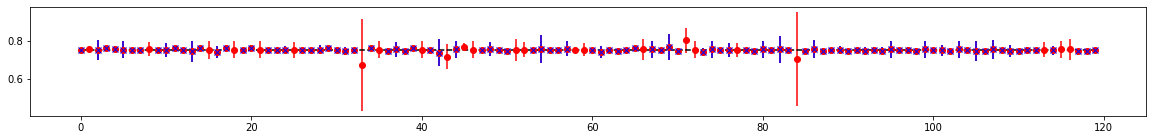

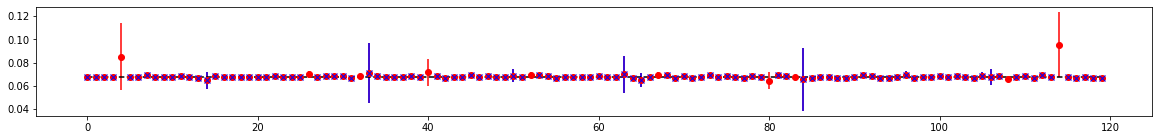

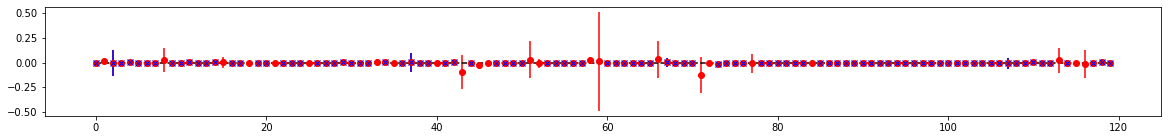

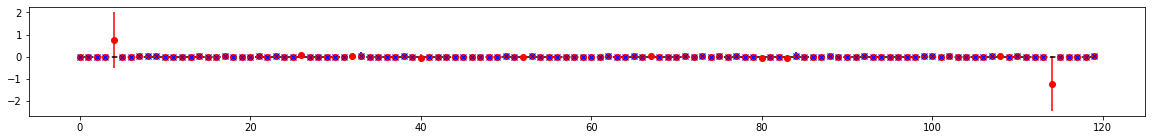

In [28]:
probe = 28
index = torch.arange(twiss.limit*(2*twiss.limit - 1))

bx, sigma_bx = twiss.data_phase['bx'][probe], twiss.data_phase['sigma_bx'][probe]
ax, sigma_ax = twiss.data_phase['ax'][probe], twiss.data_phase['sigma_ax'][probe]

by, sigma_by = twiss.data_phase['by'][probe], twiss.data_phase['sigma_by'][probe]
ay, sigma_ay = twiss.data_phase['ay'][probe], twiss.data_phase['sigma_ay'][probe]

plt.figure(figsize=(20, 2))
plt.errorbar(index, bx, yerr=sigma_bx, fmt=' ', color='red', marker='o')
plt.errorbar(index[mask_x[probe]], bx[mask_x[probe]], yerr=sigma_bx[mask_x[probe]], fmt=' ', color='blue', marker='x')
plt.hlines(model.bx[probe], 0, len(index)-1, color='black', linestyles='dashed')
plt.show()

plt.figure(figsize=(20, 2))
plt.errorbar(index, by, yerr=sigma_by, fmt=' ', color='red', marker='o')
plt.errorbar(index[mask_y[probe]], by[mask_y[probe]], yerr=sigma_by[mask_y[probe]], fmt=' ', color='blue', marker='x')
plt.hlines(model.by[probe], 0, len(index)-1, color='black', linestyles='dashed')
plt.show()

plt.figure(figsize=(20, 2))
plt.errorbar(index, ax, yerr=sigma_ax, fmt=' ', color='red', marker='o')
plt.errorbar(index[mask_x[probe]], ax[mask_x[probe]], yerr=sigma_ax[mask_x[probe]], fmt=' ', color='blue', marker='x')
plt.hlines(model.ax[probe], 0, len(index)-1, color='black', linestyles='dashed')
plt.show()

plt.figure(figsize=(20, 2))
plt.errorbar(index, ay, yerr=sigma_ay, fmt=' ', color='red', marker='o')
plt.errorbar(index[mask_y[probe]], ay[mask_y[probe]], yerr=sigma_ay[mask_y[probe]], fmt=' ', color='blue', marker='x')
plt.hlines(model.ay[probe], 0, len(index)-1, color='black', linestyles='dashed')
plt.show()

In [29]:
# COMPARE WITH FROM AMPLITUDE FOR EXAMPLES

bx


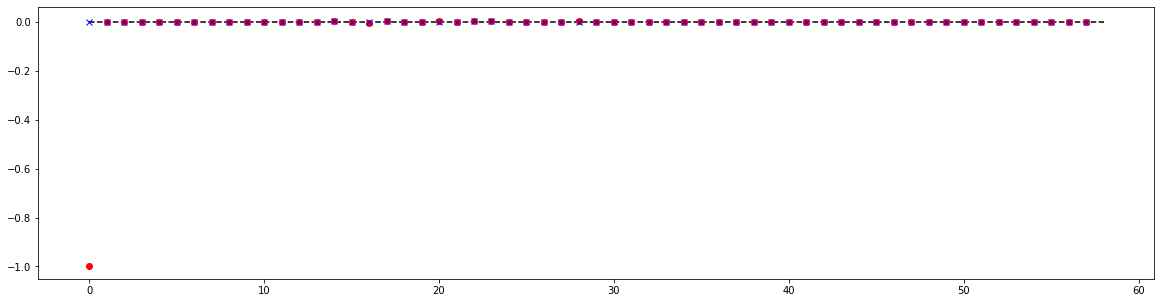

tensor(1.000069400751e+00, dtype=torch.float64)
tensor(6.074340085065e-05, dtype=torch.float64)
by


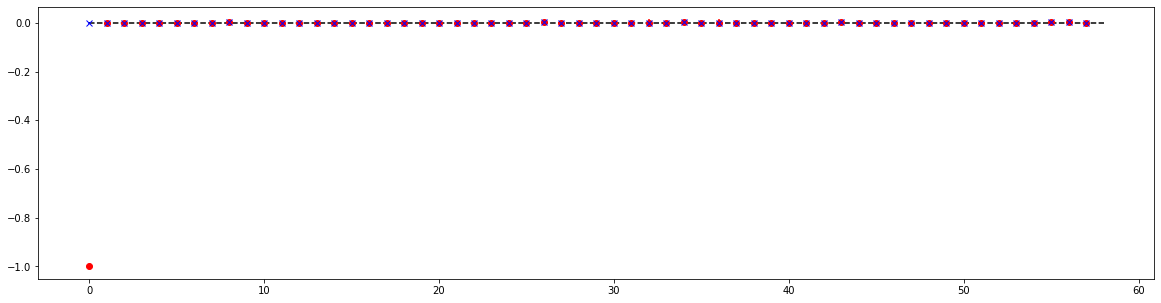

tensor(1.000065685974e+00, dtype=torch.float64)
tensor(6.651570189303e-05, dtype=torch.float64)
ax


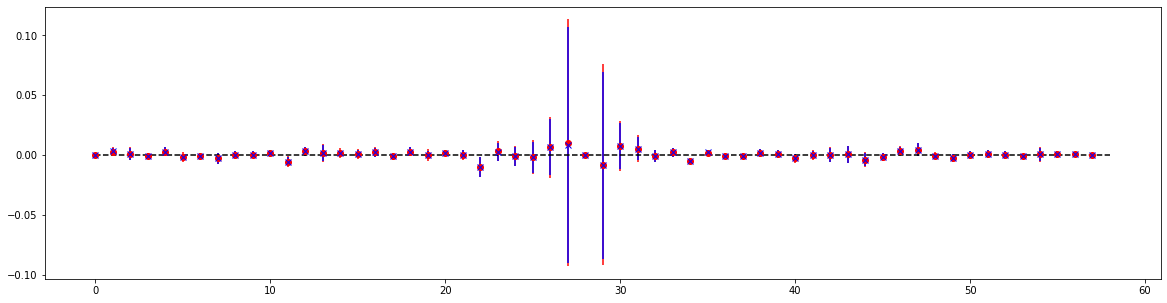

tensor(6.093765636970e-04, dtype=torch.float64)
tensor(5.956191800755e-04, dtype=torch.float64)
ay


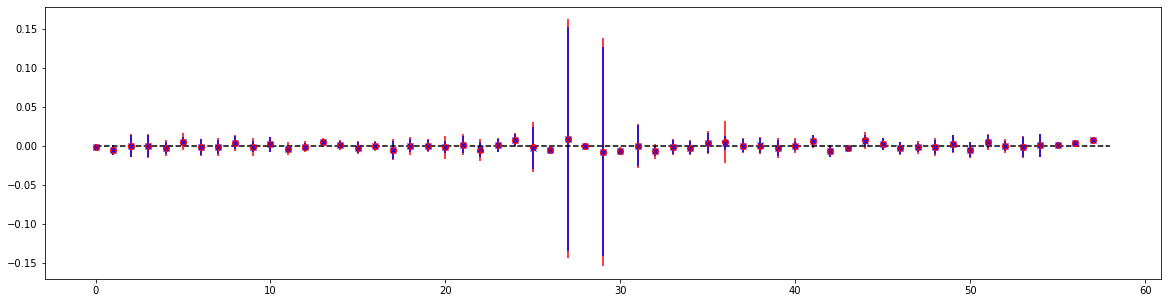

tensor(8.792030097296e-04, dtype=torch.float64)
tensor(8.421724765596e-04, dtype=torch.float64)


In [30]:
print('bx')
bx_model = twiss.model.bx[:-1]
center1 = t1x['value_b'][:-1]
spread1 = t1x['sigma_b'][:-1]
center2 = t2x['value_b'][:-1]
spread2 = t2x['sigma_b'][:-1]
plt.figure(figsize=(20, 5))
plt.errorbar(range(model.size)[:-1], (center1 - bx_model)/bx_model, yerr=spread1/bx_model, color='red', fmt=' ', marker='o')
plt.errorbar(range(model.size)[:-1], (center2 - bx_model)/bx_model, yerr=spread2/bx_model, color='blue', fmt=' ', marker='x')
plt.hlines(0, 0, model.size-1, color='black', linestyles='dashed')
plt.show()
print(torch.sum(((center1 - bx_model)/bx_model)**2))
print(torch.sum(((center2 - bx_model)/bx_model)**2))

print('by')
bx_model = twiss.model.by[:-1]
center1 = t1y['value_b'][:-1]
spread1 = t1y['sigma_b'][:-1]
center2 = t2y['value_b'][:-1]
spread2 = t2y['sigma_b'][:-1]
plt.figure(figsize=(20, 5))
plt.errorbar(range(model.size)[:-1], (center1 - bx_model)/bx_model, yerr=spread1/bx_model, color='red', fmt=' ', marker='o')
plt.errorbar(range(model.size)[:-1], (center2 - bx_model)/bx_model, yerr=spread2/bx_model, color='blue', fmt=' ', marker='x')
plt.hlines(0, 0, model.size-1, color='black', linestyles='dashed')
plt.show()
print(torch.sum(((center1 - bx_model)/bx_model)**2))
print(torch.sum(((center2 - bx_model)/bx_model)**2))

print('ax')
bx_model = twiss.model.ax[:-1]
center1 = t1x['value_a'][:-1]
spread1 = t1x['sigma_a'][:-1]
center2 = t2x['value_a'][:-1]
spread2 = t2x['sigma_a'][:-1]
plt.figure(figsize=(20, 5))
plt.errorbar(range(model.size)[:-1], (center1 - bx_model), yerr=spread1, color='red', fmt=' ', marker='o')
plt.errorbar(range(model.size)[:-1], (center2 - bx_model), yerr=spread2, color='blue', fmt=' ', marker='x')
plt.hlines(0, 0, model.size-1, color='black', linestyles='dashed')
plt.show()
print(torch.sum(((center1 - bx_model))**2))
print(torch.sum(((center2 - bx_model))**2))

print('ay')
bx_model = twiss.model.ay[:-1]
center1 = t1y['value_a'][:-1]
spread1 = t1y['sigma_a'][:-1]
center2 = t2y['value_a'][:-1]
spread2 = t2y['sigma_a'][:-1]
plt.figure(figsize=(20, 5))
plt.errorbar(range(model.size)[:-1], (center1 - bx_model), yerr=spread1, color='red', fmt=' ', marker='o')
plt.errorbar(range(model.size)[:-1], (center2 - bx_model), yerr=spread2, color='blue', fmt=' ', marker='x')
plt.hlines(0, 0, model.size-1, color='black', linestyles='dashed')
plt.show()
print(torch.sum(((center1 - bx_model))**2))
print(torch.sum(((center2 - bx_model))**2))

In [134]:
# note, if limit is none, weighted center and spread have zero in den
# note, slow loop for model advance error
# job lib for loop over location in filter? for dbscan and other
# no, not used by default
# just do not process if limit is 1
# (x-x_m)/x_m is bad for alpha close to zero

# DEV-2

In [1]:
import epics
import numpy
import pandas
import torch

import sys
sys.path.append('..')

from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition
from harmonica.model import Model
from harmonica.table import Table
from harmonica.twiss import Twiss

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = 'cpu'

In [3]:
# Compute reference parameters (frequency, amplitude and phase)

df = pandas.read_pickle('../virtual_tbt.pkl.gz')

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, torch.tensor(df.X.to_list(), dtype=dtype, device=device))
y = Data.from_data(w, torch.tensor(df.Y.to_list(), dtype=dtype, device=device))

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [4]:
# Set noise

noise_x = 1.0E-6*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-6*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

nux= 0.536883106, sigma_nux=6.30220915e-07, error_nux=6.9708701e-09

(ax - ref_ax).abs().sum().item()=8.95965142e-05

(fx - ref_fx).abs().sum().item()=  0.03066663



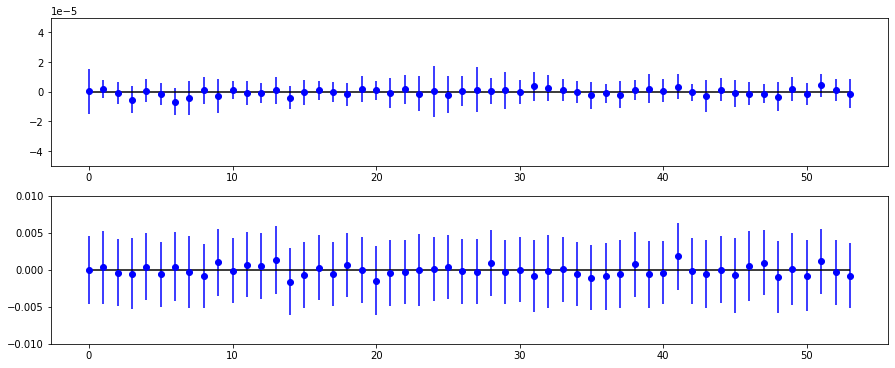

In [5]:
# Compute frequency, amplitude and phase for x plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=64, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=256, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(x.size), (ax - ref_ax).cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, x.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(x.size), (fx - ref_fx).cpu().numpy(), yerr=sigma_fx.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, x.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

nuy= 0.576774533, sigma_nuy=6.71154345e-07, error_nuy=1.00606275e-07

(ay - ref_ay).abs().sum().item()=0.000105166959

(fy - ref_fy).abs().sum().item()=0.0427046059



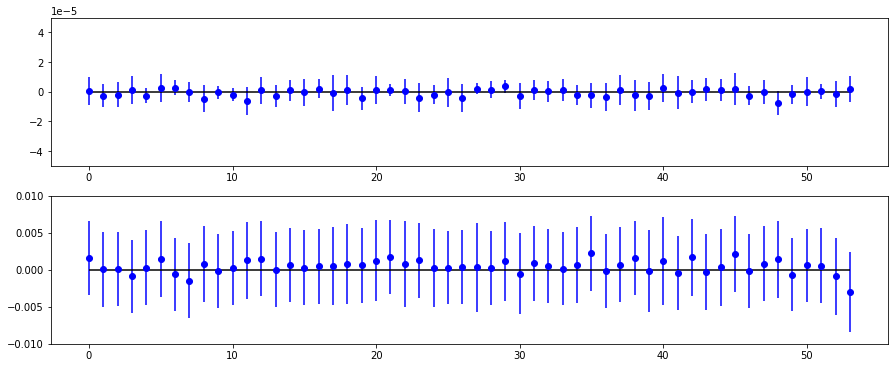

In [6]:
# Compute frequency, amplitude and phase for y plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=64, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=256, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(15, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(y.size), (ay - ref_ay).cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, y.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(y.size), (fy - ref_fy).cpu().numpy(), yerr=sigma_fy.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, y.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

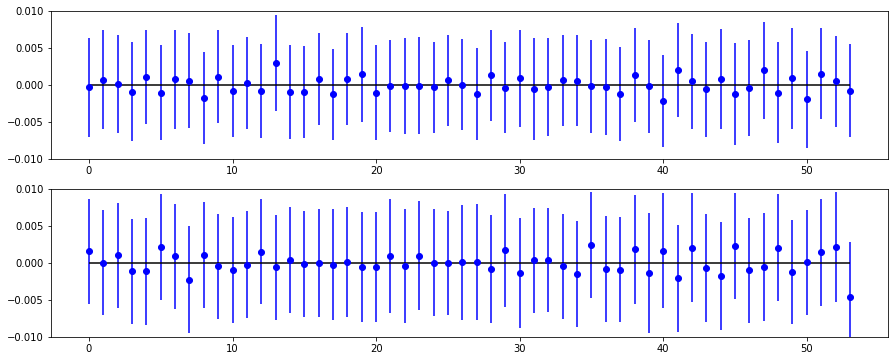

In [7]:
# Set model & table

model = Model(path='../config.yaml', dtype=dtype, device=device)
table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

# Compare phase advance between adjacent monitor locations
plt.figure(figsize=(15, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (model.monitor_phase_x - table.phase_x).cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-1.0E-2, +1.0E-2)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (model.monitor_phase_y - table.phase_y).cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)

plt.show()

In [8]:
twiss = Twiss(model, table)
twiss()

,name,kind,flag,time,ax,sigma_ax,bx,sigma_bx,fx,sigma_fx,ay,sigma_ay,by,sigma_by,fy,sigma_fy
0,HEAD,VIRTUAL,0,0.000000,-0.677935,0.001396,7.463741,0.014620,0.595965,0.000656,0.654497,0.003104,15.850004,0.051106,-0.579536,0.001160
1,STP2,MONITOR,1,0.000000,-0.677973,0.001378,7.462594,0.013611,0.595998,0.004579,0.652413,0.003101,15.862045,0.055052,-0.577895,0.004951
2,IV4P,VIRTUAL,0,4.153500,1.954417,0.003631,14.233505,0.027723,0.981739,0.000665,-2.762723,0.008092,13.868442,0.042758,-0.275738,0.001181
3,STP4,MONITOR,1,6.667000,0.381711,0.001175,3.122933,0.005395,1.433852,0.004898,3.094414,0.009095,30.460659,0.086012,-0.172354,0.005043
4,SRP1,MONITOR,1,10.190565,-0.801587,0.000993,4.739275,0.005580,2.560762,0.004491,1.841369,0.004995,13.278227,0.034236,0.002483,0.004998
5,SRP2,MONITOR,1,17.337624,-0.718171,0.000982,4.552048,0.005214,-2.623242,0.004822,1.840755,0.004380,13.277750,0.036744,0.795459,0.004973
6,SRP3,MONITOR,1,24.484683,-0.771653,0.000610,4.489232,0.003536,-1.465420,0.004534,1.845010,0.006498,13.316616,0.049692,1.588173,0.005024
7,SRP4,MONITOR,1,31.631742,-0.787342,0.000919,4.757324,0.005892,-0.354432,0.004372,1.844982,0.007797,13.303337,0.049901,2.380101,0.005147
8,SRP5,MONITOR,1,38.778801,-0.715146,0.001245,4.483323,0.007285,0.757191,0.004635,1.842553,0.005698,13.274697,0.039579,-3.111929,0.004951
9,SRP6,MONITOR,1,45.925860,-0.789487,0.001611,4.555280,0.009040,1.913771,0.004791,1.841463,0.005855,13.274246,0.045508,-2.318867,0.005078


# DEV-3: precomputed data (see inside for new examples)

In [1]:
# Import

import numpy
import pandas
import torch

import sys
sys.path.append('..')

from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.decomposition import Decomposition
from harmonica.model import Model
from harmonica.table import Table
from harmonica.twiss import Twiss

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = 'cpu'

In [3]:
# Compute reference parameters (frequency, amplitude and phase)

df = pandas.read_pickle('../virtual_tbt.pkl.gz')

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, torch.tensor(df.X.to_list(), dtype=dtype, device=device))
y = Data.from_data(w, torch.tensor(df.Y.to_list(), dtype=dtype, device=device))

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [4]:
# Set noise

noise_x = 1.0E-6*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-6*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

In [5]:
# Compute frequency, amplitude and phase for x plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=64, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=256, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

nux= 0.536883057, sigma_nux=6.91655095e-07, error_nux=4.13434388e-08

(ax - ref_ax).abs().sum().item()=9.02364588e-05

(fx - ref_fx).abs().sum().item()=0.0306304398



In [6]:
# Compute frequency, amplitude and phase for y plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=64, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=256, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

nuy= 0.576774615, sigma_nuy=6.59728659e-07, error_nuy=1.80055755e-08

(ay - ref_ay).abs().sum().item()=0.000103436909

(fy - ref_fy).abs().sum().item()=0.0392726993



In [7]:
# Set model & table

model = Model(path='../config.yaml', limit=8, error=True, dtype=dtype, device=device)
table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

In [8]:
# limit a tuple for model and direct
# check limit vs model limit
# set self.fx_ij and other -- model
# rename data, pair
# check usage of self.limit when tuple, mask generation can be like combo shape

# anomaly flags and combination mask

# METHOD TO MAKE range mask (min, max)

# mask based on limit, apply to results to get specific limit
# apply to process to get result for specific limit

In [9]:
# masks generation
# 1. rangle limit (take max range, generate, take in min max, format)
# 2. location based (see init)
# 3. distance based (self.distance for one location all combos)

In [9]:
# example of external filter
# flag = torch.clone(model.flag)
# flag[9] = 0 
# twiss = Twiss(model, table, use_model=True, limit=1, flag=flag)
# print(twiss.mask.shape)
# (twiss.combo.flatten(1)[twiss.mask.flatten().logical_not()]).reshape(-1, 2, 2)

# this might remove all combos..., but mask is a post process, should be OK
# if use model and external flags -> build combo mask
# 0 if not at probed

In [ ]:
# Example, use probe for correct
twiss.phase_correct(use_probe=True)

In [ ]:
# Example, use precomuted
twiss.get_twiss_from_phase(use_model=True)

In [10]:
twiss = Twiss(model, table, limit=8)